# Pre

In [1]:
import subprocess
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import lightgbm as lgb
import gc
from itertools import combinations
import math
import sys,os
import logging
from glob import glob
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import functools
import itertools

sys.path.append("/nfs/project/zhoutongzt/ETA/ztprivate/gbdt_eta")
sys.path.append("/nfs/project/zhoutongzt/ETA/ztprivate/gbdt_eta/models")
import core
import exp_demo
import sampleUtils
import models
from exp_demo import DropCols,CategoryCols,load_data,clean,format_type,featCols
from exp_demo import metric,metric2,metric_by_field,indicators,indicators_info,fulfillment_info
from line_time_model_train_length_fix import goods_feature_name
import line_time_model_train_length_fix
# DropCols
print(",".join(featCols))

pd.set_option('display.max_columns', 70)
pd.set_option('display.max_rows', 70)

DATA_PARSED_BY_LINE="/nfs/project/zhoutongzt/ETA/data_parsed_by_line/{}"
DATA_FP="/nfs/project/zhoutongzt/ETA/data/{}"



import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
import tensorflow.feature_column as fc
# opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
# conf = tf.ConfigProto(gpu_options=opts)
conf = tf.ConfigProto()
conf.gpu_options.allow_growth=True
conf.allow_soft_placement = True
est_conf = tf.estimator.RunConfig(session_config=conf)

from models import RNNDemo,core,RNNDemo_seqLoss,RNNDemo_seqLoss_addLineFeats

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



[2021-06-09 12:03:17-ERROR]: >>> error level on
[2021-06-09 12:03:17-INFO]: >>> info level on


age_30,age_40,age_50,age_25_q,age_50_q,age_75_q,age_mean,female_count,male_count,gender_50,store_type_25,store_type_50,store_type_75,store_type_mean,has_store_id_-1,has_store_id_0,has_store_id_1,has_store_id_2,has_store_id_3,has_store_id_mean,isnot_td_new_count,is_td_new_count,is_td_new_count_mean,is_month_new_leader,isnot_month_new_leader,is_month_new_leader_mean,delivery_id_1,delivery_id_2,delivery_id_3,delivery_id_mean,num_sum_25,num_sum_50,num_sum_75,num_sum_mean,sku_cnt_25,sku_cnt_50,sku_cnt_75,sku_cnt_mean,user_cnt_25,user_cnt_50,user_cnt_75,user_cnt_mean,gmv_25,gmv_50,gmv_75,gmv_mean,leader_uid_cnt,line_num_sum,line_gmv,line_sku_cnt,first_eta,first_length,leader_eta,leader_length,first_order_num,middle_order_num,last_order_num,delivery_flag,fruits_count,vgtble_count,fresh_count,category_id_count,refrigeration_type_0,refrigeration_type_1,refrigeration_type_2,refrigeration_type_3


# RNN

## inspect row-explode-data

In [2]:
city="9_zhengzhou"
fromDt="20210301"
toDt="20210301"
training=True
self = RNNDemo_seqLoss_addLineFeats.DataFetcher()
df = self._load_explode_data(city, fromDt, toDt)
df = self._add_extra_cols(df)
df.head(5)

[2021-05-27 12:06:25-INFO]:   _load_explode_data
[2021-05-27 12:06:25-INFO]:   _add_extra_cols


  0%|          | 0/226 [00:00<?, ?it/s]

,driver_phone_ori,date,ata,leader_uid_cnt,line_num_sum,line_gmv,fruits_count,vgtble_count,fresh_count,category_id_count,refrigeration_type_0,refrigeration_type_1,refrigeration_type_2,refrigeration_type_3,uid_str,leader_age_str,leader_sex_num_str,store_type_str,has_store_id_str,is_td_new_leader,is_month_new_leader,delivery_id_str,num_sum_str,sku_cnt_str,user_cnt_str,gmv_str,rp_eta,rp_length,leader_ata,trans_index,label,num_sum_remain,line_sku_cnt,leader_eta,leader_length,first_eta,first_length,is_td_new_count,store_type_25q,store_type_50q,store_type_75q,leader_age_25q,leader_age_50q,leader_age_75q,sku_cnt_25q,sku_cnt_50q,sku_cnt_75q,num_sum_25q,num_sum_50q,num_sum_75q
2122,13007513313,20210301,6157,34.0,807.0,3576.64,234.0,910.0,1416.0,15,1866.0,132.0,138.0,17.0,6.392473e+17,33.0,0.0,1.0,2.0,0.0,0,1.0,76.0,41.0,25.0,350.58,3218.0,34260.0,5331.0,0.0,6157,807.0,437.0,5835.0,29647.0,3218.0,34260.0,0,1.0,1.0,39.25,33.0,35.0,40.0,3.5,9.5,19.25,6.0,17.0,26.75
2123,13007513313,20210301,6157,34.0,807.0,3576.64,234.0,910.0,1416.0,15,1866.0,132.0,138.0,17.0,6.392473e+17,37.0,0.0,1.0,2.0,0.0,0,1.0,126.0,36.0,23.0,442.94,171.0,995.0,5352.0,1.0,6157,731.0,437.0,5835.0,29647.0,3218.0,34260.0,0,1.0,1.0,39.25,33.0,35.0,40.0,3.5,9.5,19.25,6.0,17.0,26.75
2124,13007513313,20210301,6157,34.0,807.0,3576.64,234.0,910.0,1416.0,15,1866.0,132.0,138.0,17.0,6.392473e+17,40.0,0.0,5.0,2.0,0.0,0,1.0,3.0,3.0,2.0,8.96,22.0,148.0,5376.0,2.0,6157,605.0,437.0,5835.0,29647.0,3218.0,34260.0,0,1.0,1.0,39.25,33.0,35.0,40.0,3.5,9.5,19.25,6.0,17.0,26.75
2125,13007513313,20210301,6157,34.0,807.0,3576.64,234.0,910.0,1416.0,15,1866.0,132.0,138.0,17.0,6.392473e+17,48.0,0.0,1.0,2.0,0.0,0,1.0,6.0,6.0,2.0,15.40,508.0,2705.0,5398.0,3.0,6157,602.0,437.0,5835.0,29647.0,3218.0,34260.0,0,1.0,1.0,39.25,33.0,35.0,40.0,3.5,9.5,19.25,6.0,17.0,26.75
2126,13007513313,20210301,6157,34.0,807.0,3576.64,234.0,910.0,1416.0,15,1866.0,132.0,138.0,17.0,6.392473e+17,36.0,1.0,1.0,2.0,0.0,0,1.0,36.0,25.0,6.0,105.69,259.0,1050.0,5417.0,4.0,6157,596.0,437.0,5835.0,29647.0,3218.0,34260.0,0,1.0,1.0,39.25,33.0,35.0,40.0,3.5,9.5,19.25,6.0,17.0,26.75


In [3]:
self.lineFeatCols

['line_num_sum',
 'line_sku_cnt',
 'leader_eta',
 'leader_length',
 'first_length',
 'first_eta',
 'is_td_new_count',
 'is_month_new_leader',
 'store_type_25q',
 'store_type_50q',
 'store_type_75q',
 'leader_age_25q',
 'leader_age_50q',
 'leader_age_75q',
 'sku_cnt_25q',
 'sku_cnt_50q',
 'sku_cnt_75q',
 'num_sum_25q',
 'num_sum_50q',
 'num_sum_75q',
 'fruits_count',
 'vgtble_count',
 'fresh_count',
 'category_id_count',
 'refrigeration_type_0',
 'refrigeration_type_1',
 'refrigeration_type_2',
 'refrigeration_type_3']

In [4]:
res = []
for keys, dfg in tqdm(df.groupby(["driver_phone_ori", "date"])):
    driver_tel, date = keys
    leader_uid_cnt = dfg['leader_uid_cnt'].iloc[0]
    label = float(dfg['label'].iloc[0])
    first_ata = dfg['leader_ata'].iloc[0]
    dfg = dfg.sort_values(by="trans_index")
    res.append([driver_tel, date, leader_uid_cnt, label]
                + dfg[self.lineFeatCols].iloc[0].values.tolist()
                + [dfg['uid_str'].values, dfg[self.cat_cols].values, dfg[self.num_cols].values,
                   dfg['leader_ata'].values, dfg['leader_ata'].values - first_ata])
    break
res_cols = ["driver_phone_ori", "date", "leader_uid_cnt", "label"] + \
                   self.lineFeatCols +\
                   ["uid_feats", "cat_feats", "num_feats", "leader_atas", "leader_atas_sub1st"]
pd.DataFrame(res, columns=res_cols)

  0%|          | 0/226 [00:00<?, ?it/s]

,driver_phone_ori,date,leader_uid_cnt,label,line_num_sum,line_sku_cnt,leader_eta,leader_length,first_length,first_eta,is_td_new_count,is_month_new_leader,store_type_25q,store_type_50q,store_type_75q,leader_age_25q,leader_age_50q,leader_age_75q,sku_cnt_25q,sku_cnt_50q,sku_cnt_75q,num_sum_25q,num_sum_50q,num_sum_75q,fruits_count,vgtble_count,fresh_count,category_id_count,refrigeration_type_0,refrigeration_type_1,refrigeration_type_2,refrigeration_type_3,uid_feats,cat_feats,num_feats,leader_atas,leader_atas_sub1st
0,13007513313,20210301,34.0,6157.0,807.0,437.0,5835.0,29647.0,34260.0,3218.0,0.0,0.0,1.0,1.0,39.25,33.0,35.0,40.0,3.5,9.5,19.25,6.0,17.0,26.75,234.0,910.0,1416.0,15.0,1866.0,132.0,138.0,17.0,"[6.392472674945518e+17, 6.392472674946003e+17,...","[[0.0, 1.0, 2.0, 0.0, 0.0, 1.0], [0.0, 1.0, 2....","[[33.0, 76.0, 41.0, 25.0, 3218.0, 34260.0, 807...","[5331.0, 5352.0, 5376.0, 5398.0, 5417.0, 5442....","[0.0, 21.0, 45.0, 67.0, 86.0, 111.0, 143.0, 16..."


In [9]:
shapeDict_common = {
        "driver_phone_ori": (),
        "date": (),
        "label": (),
        "seq_len": (),
        "sample_weight": (),
        "leader_uid_cnt": (),
    }
shapeDict_common.update({i: () for i in self.lineFeatCols})
shapeDict_common

{'driver_phone_ori': (),
 'date': (),
 'label': (),
 'seq_len': (),
 'sample_weight': (),
 'leader_uid_cnt': (),
 'line_num_sum': (),
 'line_sku_cnt': (),
 'leader_eta': (),
 'leader_length': (),
 'first_length': (),
 'first_eta': (),
 'is_td_new_count': (),
 'is_month_new_leader': (),
 'store_type_25q': (),
 'store_type_50q': (),
 'store_type_75q': (),
 'leader_age_25q': (),
 'leader_age_50q': (),
 'leader_age_75q': (),
 'sku_cnt_25q': (),
 'sku_cnt_50q': (),
 'sku_cnt_75q': (),
 'num_sum_25q': (),
 'num_sum_50q': (),
 'num_sum_75q': (),
 'fruits_count': (),
 'vgtble_count': (),
 'fresh_count': (),
 'category_id_count': (),
 'refrigeration_type_0': (),
 'refrigeration_type_1': (),
 'refrigeration_type_2': (),
 'refrigeration_type_3': ()}

In [ ]:
# goods_feature_name = ['fruits_count', 'vgtble_count', 'fresh_count', 'category_id_count',
#                               'refrigeration_type_0', 'refrigeration_type_1', 'refrigeration_type_2',
#                               'refrigeration_type_3']
# self.lineFeatCols = ["leader_uid_cnt", "line_num_sum", "line_sku_cnt",
#                      "leader_eta", "leader_length", "first_length", "first_eta",
#                      "isnot_td_new_count", "is_month_new_leader",
#                      "store_type_50q", "age_50q", "sku_cnt_50q", "num_sum_50q"]\
#                     + goods_feature_name


In [47]:
inpDF=df
for keys, dfg in tqdm(inpDF.groupby(["driver_phone_ori", "date"])):
    keys
    dfg.head(2)
    break
    
dfg['line_sku_cnt'] = dfg['sku_cnt_str'].sum()
first_rp_eta = dfg.sort_values("trans_index")['rp_eta'].iloc[0]
first_rp_length = dfg.sort_values("trans_index")['rp_length'].iloc[0]
dfg['leader_eta'] = dfg['rp_eta'].sum() - first_rp_eta
dfg['leader_length'] = dfg['rp_length'].sum() - first_rp_length
dfg['first_eta'] = first_rp_eta
dfg['first_length'] = first_rp_length
dfg['is_td_new_count'] = dfg['is_td_new_leader'].tolist().count(1)
dfg['is_month_new_leader'] = dfg['is_month_new_leader'].tolist().count(1)
for col in ['store_type',"leader_age","sku_cnt","num_sum"]:
    dfg[col+"_25q"] = np.percentile(dfg[col+"_str"],25)
    dfg[col+"_50q"] = np.percentile(dfg[col+"_str"],50)
    dfg[col+"_75q"] = np.percentile(dfg[col+"_str"],75)
# dfg['store_type_50q'] = np.percentile(dfg['store_type_str'],50)
# dfg['age_50q'] = np.percentile(dfg['leader_age_str'],50)
# dfg['sku_cnt_50q'] = np.percentile(dfg[''])







  0%|          | 0/226 [00:00<?, ?it/s]

(13007513313, 20210301)

,driver_phone_ori,date,ata,leader_uid_cnt,line_num_sum,line_gmv,fruits_count,vgtble_count,fresh_count,category_id_count,refrigeration_type_0,refrigeration_type_1,refrigeration_type_2,refrigeration_type_3,uid_str,leader_age_str,leader_sex_num_str,store_type_str,has_store_id_str,is_td_new_leader,is_month_new_leader,delivery_id_str,num_sum_str,sku_cnt_str,user_cnt_str,gmv_str,rp_eta,rp_length,leader_ata,trans_index,label,num_sum_remain
2122,13007513313,20210301,6157,34.0,807.0,3576.64,234.0,910.0,1416.0,15,1866.0,132.0,138.0,17.0,6.392473e+17,33.0,0.0,1.0,2.0,0.0,0.0,1.0,76.0,41.0,25.0,350.58,3218.0,34260.0,5331.0,0.0,6157,807.0
2123,13007513313,20210301,6157,34.0,807.0,3576.64,234.0,910.0,1416.0,15,1866.0,132.0,138.0,17.0,6.392473e+17,37.0,0.0,1.0,2.0,0.0,0.0,1.0,126.0,36.0,23.0,442.94,171.0,995.0,5352.0,1.0,6157,731.0


In [40]:
_city="9_zhengzhou"
_date="20210301"
res = []

line="13007513313;;61,31,33,35,33,31,57,30,31,46,29,34,32,36,34,33,33,30,30,48,48,48,42,45,58,32,47,35,28,30,50,31,33;;0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,1,1,0,0,0,1,0,0,0,1,1,0,1,1,0,1,1,0;;1,1,2,7,2,2,1,50,1,1,50,50,2,2,50,50,50,2,5,2,1,1,1,50,4,1,1,3,1,1,1,4,1;;1,2,1,1,1,1,2,2,2,2,1,1,1,1,2,2,1,1,2,1,2,2,1,2,2,2,2,1,2,2,2,2,2;;0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0;;0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0;;3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,1,1,1,1,1;;41,2,32,24,31,108,23,12,14,13,26,7,4,46,4,25,32,5,1,15,76,28,20,18,12,20,10,68,5,5,71,19,4;;22,2,20,17,23,66,4,10,6,8,11,6,4,21,3,13,28,3,1,12,30,24,3,5,9,11,3,48,4,4,27,15,4;;13,2,10,8,6,13,1,1,4,2,1,2,1,23,1,3,5,5,1,3,29,3,1,3,6,5,1,8,2,1,15,1,2;;246.85,7.19,175.3,179.75,177.26,850.15,42.96,99.94,30.049999999999997,55.870000000000005,173.49,78.57,13.82,341.81000000000006,5.03,117.11999999999999,130.73000000000002,12.850000000000001,4.99,42.68000000000001,644.6300000000001,224.17999999999995,142.0,47.879999999999995,93.26999999999998,207.96,40.519999999999996,296.50999999999993,16.64,12.64,215.85,74.73,22.36;;33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33;;821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0,821.0;;4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001,4825.580000000001;;2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13,2021-02-08 06:54:13;;2021-02-08 10:32:57,2021-02-08 10:34:49,2021-02-08 10:17:29,2021-02-08 10:04:09,2021-02-08 10:03:48,2021-02-08 10:35:51,2021-02-08 10:35:21,2021-02-08 10:34:00,2021-02-08 10:31:46,2021-02-08 10:36:02,2021-02-08 10:04:32,2021-02-08 10:34:11,2021-02-08 10:05:04,2021-02-08 10:32:41,2021-02-08 10:06:17,2021-02-08 10:34:22,2021-02-08 10:33:14,2021-02-08 10:17:02,2021-02-08 10:04:48,2021-02-08 10:17:45,2021-02-08 10:30:20,2021-02-08 10:33:42,2021-02-08 10:05:21,2021-02-08 10:34:35,2021-02-08 10:18:06,2021-02-08 10:05:56,2021-02-08 10:30:32,2021-02-08 10:31:11,2021-02-08 10:32:17,2021-02-08 10:18:46,2021-02-08 10:18:21,2021-02-08 10:31:28,2021-02-08 10:32:05;;164.0,318.0,769.0,13,1135.0,116.0,111.0,0.0;;639247268309485667,639247267520633963,639247268403456155,639247267798239857,639247267553210772,639247267485849386,639247267538786279,639247268115702842,639247267523810011,639247267561307772,639247268495923022,639247268120738864,639247268495452287,639247267653804670,639247267556532882,639247267707149783,639247268563411279,639247268411649921,639247267483818532,639247267999959147,639247267491196756,639247267599777803,639247267483181225,639247267521304781,639247267654258946,639264856628657602,639247267491183196,639247267511012241,639247267534502682,639247267522470552,639247267524431836,639247267547156583,639247267536255682;;0_2752_32321_2752,1_179_884_179,2_71_241_71,3_30_193_30,4_189_1065_189,5_118_521_118,6_102_464_102,7_219_1212_219,8_264_1557_264,9_11_86_11,10_98_649_98,11_39_235_39,12_110_694_110,13_0_0_0,14_97_567_97,15_90_624_90,16_70_480_70,17_60_456_60,18_117_648_117,19_339_1900_339,20_155_1075_155,21_285_1557_285,22_229_1261_229,23_125_810_125,24_1_10_1,25_296_1855_296,26_0_1_0,27_19_131_19,28_2_16_2,29_229_1305_229,30_261_1425_261,31_208_1242_208,32_192_1256_192".split(";;")
driver_phone_ori, leader_age_str, leader_sex_num_str, store_type_str, has_store_id_str, is_td_new_leader, is_month_new_leader, delivery_id_str, num_sum_str, \
sku_cnt_str, user_cnt_str, gmv_str, leader_uid_cnt_str, line_num_sum_str, line_gmv_str, tocar_time_str, max_action_time_str, \
good_item_str, uid_str, eta_str = line
good_item_str
leader_uid_cnt_str





leader_uid_cnt = float(leader_uid_cnt_str.split(",")[0])
line_num_sum = float(line_num_sum_str.split(",")[0])
line_gmv = float(line_gmv_str.split(",")[0])
tocar_time = tocar_time_str.split(",")[0]
good_item_list = good_item_str.split(",")
# ATA解析
leader_ata = [datetime.strptime(t, "%Y-%m-%d %H:%M:%S") - datetime.strptime(tocar_time, "%Y-%m-%d %H:%M:%S")
            for t in max_action_time_str.split(",")]
leader_ata = [i.seconds for i in leader_ata]
line_ata = max(leader_ata)

# RP_ETA解析
# eta_str存的是配送顺序，但是max_action_time包括其他都不是配送顺序，重排后拿到配送index下各个item的原始index
assert len(max_action_time_str.split(",")) == len(eta_str.split(","))
oriIndex = [i[0] for i in sorted(enumerate(max_action_time_str.split(",")), key=lambda x: x[1])]
eta_str_oriIndex = [i[1] for i in sorted(zip(oriIndex, eta_str.split(",")), key=lambda x: x[0])]
# 注意最后按trans_index重新排序得到配送顺序
trans_index = [i.split("_")[0] for i in eta_str_oriIndex]
rp_eta = [i.split("_")[1] for i in eta_str_oriIndex]
rp_length = [i.split("_")[2] for i in eta_str_oriIndex]

# 其他特征直接逗号分隔
leaderFeats = [uid_str, leader_age_str, leader_sex_num_str, store_type_str, has_store_id_str, is_td_new_leader,is_month_new_leader,delivery_id_str,num_sum_str,sku_cnt_str,user_cnt_str,gmv_str]
allFeats = [feat.split(",") for feat in leaderFeats] + [rp_eta, rp_length, leader_ata, trans_index]
allFeats = np.vstack(allFeats).T.astype(float)
allFeats = allFeats[allFeats[:, -1].argsort()]  # 按每行的最后一个元素trans_index排序拿到实际配送顺序下的样本序列

line_features = [driver_phone_ori, _date, line_ata, leader_uid_cnt, line_num_sum, line_gmv] + good_item_list
concatFeats = [line_features + list(feats) for feats in allFeats]
res.extend(concatFeats)

line_features
pd.DataFrame(concatFeats)


'164.0,318.0,769.0,13,1135.0,116.0,111.0,0.0'

'33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33'

['13007513313',
 '20210301',
 13309,
 33.0,
 821.0,
 4825.580000000001,
 '164.0',
 '318.0',
 '769.0',
 '13',
 '1135.0',
 '116.0',
 '111.0',
 '0.0']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,13007513313,20210301,13309,33.0,821.0,4825.58,164.0,318.0,769.0,13,1135.0,116.0,111.0,0.0,6.392473e+17,33.0,0.0,2.0,1.0,0.0,0.0,1.0,31.0,23.0,6.0,177.26,2752.0,32321.0,11375.0,0.0
1,13007513313,20210301,13309,33.0,821.0,4825.58,164.0,318.0,769.0,13,1135.0,116.0,111.0,0.0,6.392473e+17,35.0,0.0,7.0,1.0,0.0,0.0,1.0,24.0,17.0,8.0,179.75,179.0,884.0,11396.0,1.0
2,13007513313,20210301,13309,33.0,821.0,4825.58,164.0,318.0,769.0,13,1135.0,116.0,111.0,0.0,6.392473e+17,29.0,0.0,50.0,1.0,0.0,0.0,1.0,26.0,11.0,1.0,173.49,71.0,241.0,11419.0,2.0
3,13007513313,20210301,13309,33.0,821.0,4825.58,164.0,318.0,769.0,13,1135.0,116.0,111.0,0.0,6.392473e+17,30.0,0.0,5.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,4.99,30.0,193.0,11435.0,3.0
4,13007513313,20210301,13309,33.0,821.0,4825.58,164.0,318.0,769.0,13,1135.0,116.0,111.0,0.0,6.392473e+17,32.0,1.0,2.0,1.0,0.0,0.0,1.0,4.0,4.0,1.0,13.82,189.0,1065.0,11451.0,4.0
5,13007513313,20210301,13309,33.0,821.0,4825.58,164.0,318.0,769.0,13,1135.0,116.0,111.0,0.0,6.392473e+17,42.0,0.0,1.0,1.0,0.0,0.0,1.0,20.0,3.0,1.0,142.00,118.0,521.0,11468.0,5.0
6,13007513313,20210301,13309,33.0,821.0,4825.58,164.0,318.0,769.0,13,1135.0,116.0,111.0,0.0,6.392649e+17,32.0,1.0,1.0,2.0,0.0,0.0,1.0,20.0,11.0,5.0,207.96,102.0,464.0,11503.0,6.0
7,13007513313,20210301,13309,33.0,821.0,4825.58,164.0,318.0,769.0,13,1135.0,116.0,111.0,0.0,6.392473e+17,34.0,1.0,50.0,2.0,0.0,0.0,1.0,4.0,3.0,1.0,5.03,219.0,1212.0,11524.0,7.0
8,13007513313,20210301,13309,33.0,821.0,4825.58,164.0,318.0,769.0,13,1135.0,116.0,111.0,0.0,6.392473e+17,30.0,0.0,2.0,1.0,0.0,0.0,1.0,5.0,3.0,5.0,12.85,264.0,1557.0,12169.0,8.0
9,13007513313,20210301,13309,33.0,821.0,4825.58,164.0,318.0,769.0,13,1135.0,116.0,111.0,0.0,6.392473e+17,33.0,0.0,2.0,1.0,0.0,0.0,1.0,32.0,20.0,10.0,175.30,11.0,86.0,12196.0,9.0


In [35]:
self=core.DataFetcher()
df = self._load_explode_data("9_zhengzhou", "20210301","20210301")

[2021-06-03 17:31:09-INFO]:   _load_explode_data


In [41]:
def _add_extra_cols(inpDF):
    logging.info("  _add_extra_cols")
    line_num_sum = inpDF['line_num_sum'].iloc[0]
    res = []
    columns=[]
    for keys, dfg in tqdm(inpDF.groupby(["driver_phone_ori", "date"])):
        dfg = dfg.sort_values("trans_index")
        line_num_sum = dfg['line_num_sum'].iloc[0]
        num_sum_cur = dfg['num_sum_str'].tolist()
#         dfg['num_sum_remain'] = dfg.apply(lambda row:
#                                           line_num_sum - sum(num_sum_cur[:int(row['trans_index'])]), axis=1)
        # 线层面全局特征 | 商品特征已在 data_parse 时加入
        dfg['line_sku_cnt'] = dfg['sku_cnt_str'].sum()
        first_rp_eta = dfg['rp_eta'].iloc[0]
        first_rp_length = dfg['rp_length'].iloc[0]
        dfg['leader_eta'] = dfg['rp_eta'].sum() - first_rp_eta
        dfg['leader_length'] = dfg['rp_length'].sum() - first_rp_length
        dfg['first_eta'] = first_rp_eta
        dfg['first_length'] = first_rp_length
        dfg['is_td_new_count'] = dfg['is_td_new_leader'].tolist().count(1)
        dfg['is_month_new_leader_count'] = dfg['is_month_new_leader'].tolist().count(1)
#         for col in ['store_type', "leader_age", "sku_cnt", "num_sum"]:
#             dfg[col + "_25q"] = np.percentile(dfg[col + "_str"], 25)
#             dfg[col + "_50q"] = np.percentile(dfg[col + "_str"], 50)
#             dfg[col + "_75q"] = np.percentile(dfg[col + "_str"], 75)
        res.append(dfg)
    inpDF_concat = pd.concat(res)
    return inpDF_concat

_add_extra_cols(df)

[2021-06-03 17:33:38-INFO]:   _add_extra_cols


  0%|          | 0/226 [00:00<?, ?it/s]

,driver_phone_ori,date,ata,leader_uid_cnt,line_num_sum,line_gmv,fruits_count,vgtble_count,fresh_count,category_id_count,refrigeration_type_0,refrigeration_type_1,refrigeration_type_2,refrigeration_type_3,uid_str,leader_age_str,leader_sex_num_str,store_type_str,has_store_id_str,is_td_new_leader,is_month_new_leader,delivery_id_str,num_sum_str,sku_cnt_str,user_cnt_str,gmv_str,rp_eta,rp_length,leader_ata,trans_index,label,line_sku_cnt,leader_eta,leader_length,first_eta,first_length,is_td_new_count,is_month_new_leader_count
2122,13007513313,20210301,6157,34.0,807.0,3576.64,234.0,910.0,1416.0,15,1866.0,132.0,138.0,17.0,6.392473e+17,33.0,0.0,1.0,2.0,0.0,0.0,1.0,76.0,41.0,25.0,350.58,3218.0,34260.0,5331.0,0.0,6157,437.0,5835.0,29647.0,3218.0,34260.0,0,0
2123,13007513313,20210301,6157,34.0,807.0,3576.64,234.0,910.0,1416.0,15,1866.0,132.0,138.0,17.0,6.392473e+17,37.0,0.0,1.0,2.0,0.0,0.0,1.0,126.0,36.0,23.0,442.94,171.0,995.0,5352.0,1.0,6157,437.0,5835.0,29647.0,3218.0,34260.0,0,0
2124,13007513313,20210301,6157,34.0,807.0,3576.64,234.0,910.0,1416.0,15,1866.0,132.0,138.0,17.0,6.392473e+17,40.0,0.0,5.0,2.0,0.0,0.0,1.0,3.0,3.0,2.0,8.96,22.0,148.0,5376.0,2.0,6157,437.0,5835.0,29647.0,3218.0,34260.0,0,0
2125,13007513313,20210301,6157,34.0,807.0,3576.64,234.0,910.0,1416.0,15,1866.0,132.0,138.0,17.0,6.392473e+17,48.0,0.0,1.0,2.0,0.0,0.0,1.0,6.0,6.0,2.0,15.40,508.0,2705.0,5398.0,3.0,6157,437.0,5835.0,29647.0,3218.0,34260.0,0,0
2126,13007513313,20210301,6157,34.0,807.0,3576.64,234.0,910.0,1416.0,15,1866.0,132.0,138.0,17.0,6.392473e+17,36.0,1.0,1.0,2.0,0.0,0.0,1.0,36.0,25.0,6.0,105.69,259.0,1050.0,5417.0,4.0,6157,437.0,5835.0,29647.0,3218.0,34260.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2363,19937539513,20210301,9160,34.0,873.0,3129.14,227.0,929.0,1568.0,14,1879.0,93.0,178.0,15.0,6.392473e+17,35.0,1.0,50.0,2.0,0.0,0.0,1.0,6.0,5.0,1.0,22.66,12.0,70.0,8870.0,29.0,9160,456.0,7350.0,31493.0,3239.0,29756.0,0,0
2364,19937539513,20210301,9160,34.0,873.0,3129.14,227.0,929.0,1568.0,14,1879.0,93.0,178.0,15.0,6.392473e+17,31.0,0.0,7.0,1.0,0.0,0.0,1.0,69.0,44.0,13.0,317.62,402.0,1957.0,8903.0,30.0,9160,456.0,7350.0,31493.0,3239.0,29756.0,0,0
2365,19937539513,20210301,9160,34.0,873.0,3129.14,227.0,929.0,1568.0,14,1879.0,93.0,178.0,15.0,6.392473e+17,30.0,0.0,5.0,2.0,0.0,0.0,1.0,10.0,4.0,2.0,37.90,156.0,652.0,8943.0,31.0,9160,456.0,7350.0,31493.0,3239.0,29756.0,0,0
2366,19937539513,20210301,9160,34.0,873.0,3129.14,227.0,929.0,1568.0,14,1879.0,93.0,178.0,15.0,6.392473e+17,28.0,0.0,3.0,2.0,0.0,0.0,1.0,4.0,3.0,1.0,23.37,109.0,456.0,8966.0,32.0,9160,456.0,7350.0,31493.0,3239.0,29756.0,0,0


## load & inspect cur-data

In [2]:
city="17_chengdu"
fromDt="20210301"
toDt="20210301"
training=True
self = RNNDemo_seqLoss.DataFetcher()
df = self._load_explode_data(city, fromDt, toDt)
df = self._add_extra_cols(df)
logging.info("\n%s" % str(df[self.num_cols].describe()))

# 处理category类特征
logging.info(">>> 处理category类特征")
if training:
    self.catIdx = {}
    curIdx = 0
    for col in self.cat_cols:
        for feat in np.sort(df[col].unique()):
            self.catIdx.update({"%s=%s" % (col, feat): curIdx})
            curIdx += 1

for col in self.cat_cols:
    df[col] = df[col].apply(lambda x: self.catIdx.get("%s=%s" % (col, x), -1)).astype(int)
    logging.info("feat: %s OOV-rate: %.4f" % (col, df[col].value_counts().to_dict().get(-1, 0)/df.shape[0]))

logging.info(">>> 处理id类特征(emb)")
if training:
    self.uidIdx = {}
    curIdx = 0
    for feat in np.sort(df['uid_str'].unique()):
        self.uidIdx.update({"%s=%s" % ('uid_str', feat): curIdx})
        curIdx += 1

df['uid_str'] = df['uid_str'].apply(lambda x: self.uidIdx.get("%s=%s" % ("uid_str", x), -1)).astype(int)
logging.info("id-feat: %s OOV-rate: %.4f" % ('uid_str', df['uid_str'].value_counts().to_dict().get(-1, 0) / df.shape[0]))

logging.info(">>> 处理numeric特征（归一化）")
if training:
    self.numMinMax = {}
    for col in self.num_cols:
        self.numMinMax.update({col: {"min": df[col].min(), "max": df[col].max()}})

for col in self.num_cols:
    df[col] = df[col].apply(lambda x: (x - self.numMinMax[col]['min']) / (self.numMinMax[col]['max'] - self.numMinMax[col]['min']))
    logging.info("feat: %s min:%.4f max:%.4f 25p:%.4f 50p:%.4f 75p:%.4f" % (col, df[col].min(), df[col].max(),
                                                                            np.percentile(df[col], 25),
                                                                            np.percentile(df[col], 50),
                                                                            np.percentile(df[col], 75)))
logging.info("\n%s" % str(df[self.num_cols].describe()))

# 聚合成序列样本
# logging.info(">>> 聚合成序列样本")
# res = []
# for keys, dfg in tqdm(df.groupby(["driver_phone_ori", "date"])):
#     driver_tel, date = keys
#     leader_uid_cnt = dfg['leader_uid_cnt'].iloc[0]
#     label = float(dfg['label'].iloc[0])
#     first_ata = dfg['leader_ata'].iloc[0]
#     dfg = dfg.sort_values(by="trans_index")
#     res.append([driver_tel, date, leader_uid_cnt, label,
#                 dfg['uid_str'].values, dfg[self.cat_cols].values, dfg[self.num_cols].values,
#                 dfg['leader_ata'].values, dfg['leader_ata'].values - first_ata])


[2021-05-26 19:21:35-INFO]:   _load_explode_data
[2021-05-26 19:21:35-INFO]:   _add_extra_cols


  0%|          | 0/181 [00:00<?, ?it/s]

[2021-05-26 19:21:36-INFO]: 
       leader_age_str  num_sum_str  sku_cnt_str  user_cnt_str       rp_eta  \
count     5340.000000  5340.000000  5340.000000   5340.000000  5340.000000   
mean        40.058989    16.879026    10.052622      4.752622   226.199813   
std          9.953181    34.847942    13.516635      6.760564   488.366168   
min          4.000000     1.000000     1.000000      1.000000     0.000000   
25%         32.000000     4.000000     2.000000      1.000000    39.000000   
50%         39.000000     9.000000     6.000000      3.000000   113.000000   
75%         48.000000    19.000000    13.000000      5.000000   226.000000   
max         85.000000   911.000000   200.000000    110.000000  5331.000000   

          rp_length  num_sum_remain  
count   5340.000000     5340.000000  
mean    1535.932210      219.006367  
std     4725.437658      173.158279  
min        0.000000     -806.000000  
25%      207.000000       99.000000  
50%      554.000000      210.000000  
75

In [9]:
max(self.uidIdx.values())
max(self.catIdx.values())

5281

17

In [10]:
pd.read_pickle("/nfs/project/zhoutongzt/ETA/ztprivate/gbdt_eta/models/TMPTrain.pkl")

,driver_phone_ori,date,leader_uid_cnt,label,uid_feats,cat_feats,num_feats,leader_atas,leader_atas_sub1st,warehouse_code_str,seq_len
0,13007513313,20210301,34.0,6157.0,"[641, 647, 861, 1379, 1424, 1514, 1531, 1600, ...","[[0, 3, 12, 13, 15, 17], [0, 3, 12, 13, 15, 17...","[[0.23529411764705882, 0.018914883026381283, 0...","[5331.0, 5352.0, 5376.0, 5398.0, 5417.0, 5442....","[0.0, 21.0, 45.0, 67.0, 86.0, 111.0, 143.0, 16...",9_zhengzhou,34
1,13007513313,20210302,32.0,13897.0,"[641, 1600, 23095, 13946, 23207, 2205, 11918, ...","[[0, 3, 12, 13, 15, 17], [0, 3, 11, 13, 15, 17...","[[0.23529411764705882, 0.04081632653061224, 0....","[11555.0, 11577.0, 11776.0, 11802.0, 11825.0, ...","[0.0, 22.0, 221.0, 247.0, 270.0, 623.0, 643.0,...",9_zhengzhou,32
2,13007513313,20210303,32.0,8904.0,"[1600, 641, 23095, 23207, 12136, 9786, 2606, 1...","[[0, 3, 11, 13, 15, 17], [0, 3, 12, 13, 15, 17...","[[0.22058823529411764, 0.010701841712294675, 0...","[4405.0, 4455.0, 4575.0, 4602.0, 4634.0, 4670....","[0.0, 50.0, 170.0, 197.0, 229.0, 265.0, 294.0,...",9_zhengzhou,32
3,13007513313,20210304,20.0,12627.0,"[1482, 1464, 6346, 2338, 2326, 14806, 14699, 7...","[[1, 3, 12, 13, 15, 17], [0, 10, 12, 13, 15, 1...","[[0.38235294117647056, 0.17496266799402688, 0....","[6073.0, 8322.0, 8338.0, 8358.0, 8373.0, 9394....","[0.0, 2249.0, 2265.0, 2285.0, 2300.0, 3321.0, ...",9_zhengzhou,20
4,13007513313,20210305,31.0,15722.0,"[1506, 1482, 2326, 9042, 10244, 2521, 2722, 15...","[[0, 3, 11, 13, 15, 17], [1, 3, 12, 13, 15, 17...","[[0.27941176470588236, 0.006968641114982578, 0...","[12485.0, 12506.0, 12526.0, 13811.0, 13822.0, ...","[0.0, 21.0, 41.0, 1326.0, 1337.0, 1351.0, 1370...",9_zhengzhou,31
...,...,...,...,...,...,...,...,...,...,...,...
13509,19946165089_5503,20210410,34.0,16068.0,"[2087, 12196, 6240, 18282, 18162, 19836, 1541,...","[[0, 10, 11, 13, 15, 17], [0, 4, 11, 13, 15, 1...","[[0.23529411764705882, 0.026381284221005476, 0...","[7396.0, 7414.0, 7428.0, 7445.0, 7467.0, 7477....","[0.0, 18.0, 32.0, 49.0, 71.0, 81.0, 1469.0, 14...",9_zhengzhou,34
13510,19946165089_5503,20210411,31.0,17346.0,"[22479, 2541, 8903, 8297, 16146, 21640, 22528,...","[[1, 10, 11, 13, 16, 17], [1, 3, 12, 13, 15, 1...","[[0.45588235294117646, 0.028621204579392732, 0...","[6970.0, 7369.0, 7686.0, 8502.0, 8520.0, 8970....","[0.0, 399.0, 716.0, 1532.0, 1550.0, 2000.0, 25...",9_zhengzhou,31
13511,19946165089_5503,20210412,37.0,15882.0,"[21640, 2541, 22479, 15607, 8903, 22077, 16146...","[[0, 9, 11, 13, 15, 17], [1, 3, 12, 13, 15, 17...","[[0.6764705882352942, 0.0821304131408661, 0.02...","[6114.0, 7136.0, 8294.0, 8990.0, 9188.0, 9674....","[0.0, 1022.0, 2180.0, 2876.0, 3074.0, 3560.0, ...",9_zhengzhou,37
13512,19946165089_5503,20210414,31.0,15472.0,"[6240, 12196, 2087, 1541, 8111, 6526, 2411, 15...","[[0, 4, 11, 13, 15, 17], [0, 4, 11, 13, 15, 17...","[[0.3088235294117647, 0.002239920358387257, 0....","[6841.0, 6853.0, 7921.0, 7938.0, 7954.0, 7973....","[0.0, 12.0, 1080.0, 1097.0, 1113.0, 1132.0, 30...",9_zhengzhou,31


In [12]:
",".join(['"%s"'% i for i in self.num_cols])

'"leader_age_str","num_sum_str","sku_cnt_str","user_cnt_str","rp_eta","rp_length","num_sum_remain","uid_str"'

In [57]:
trainDF=pd.read_pickle("/nfs/project/zhoutongzt/ETA/ztprivate/gbdt_eta/models/17_chengdu_train.pkl")
testDF=pd.read_pickle("/nfs/project/zhoutongzt/ETA/ztprivate/gbdt_eta/models/17_chengdu_test.pkl")
trainDF.head(2)
trainDF['label'].iloc[0]
trainDF['leader_atas'].iloc[0]
trainDF['leader_atas_sub1st'].iloc[0]
trainDF['num_feats'].iloc[0].shape,trainDF['num_feats'].iloc[0][:2]

def process_to_2stage(inpDF):
    inpDF['first_ata'] = inpDF['leader_atas'].apply(lambda x: x[0])
    for col in ['cat_feats', 'num_feats', 'leader_atas', 'leader_atas_sub1st']:
        inpDF[col] = inpDF[col].apply(lambda x: x[1:])
    return inpDF

trainDF = process_to_2stage(trainDF)
trainDF.head(2)
trainDF['label'].iloc[0]
trainDF['leader_atas'].iloc[0]
trainDF['leader_atas_sub1st'].iloc[0]
trainDF['num_feats'].iloc[0].shape,trainDF['num_feats'].iloc[0][:2]

,driver_phone_ori,date,leader_uid_cnt,label,cat_feats,num_feats,leader_atas,leader_atas_sub1st
0,13086618239,20210302,32.0,15358.0,"[[0, 3, 13, 14, 15, 17], [0, 5, 13, 14, 15, 17...","[[0.43209876543209874, 0.005708169818052087, 0...","[10976.0, 11016.0, 11030.0, 11043.0, 11058.0, ...","[0.0, 40.0, 54.0, 67.0, 82.0, 96.0, 109.0, 122..."
1,13086618239,20210305,34.0,15319.0,"[[0, 3, 13, 14, 15, 17], [1, 10, 12, 14, 15, 1...","[[0.35802469135802467, 0.07420620763467713, 0....","[13671.0, 13690.0, 13704.0, 13719.0, 13733.0, ...","[0.0, 19.0, 33.0, 48.0, 62.0, 77.0, 95.0, 150...."


15358.0

array([10976., 11016., 11030., 11043., 11058., 11072., 11085., 11098.,
       11111., 11124., 11138., 11155., 11168., 11181., 11193., 11208.,
       11220., 11233., 11245., 11262., 11275., 11288., 11307., 11321.,
       11337., 11351., 11364., 11377., 11391., 11405., 13803., 15358.])

array([   0.,   40.,   54.,   67.,   82.,   96.,  109.,  122.,  135.,
        148.,  162.,  179.,  192.,  205.,  217.,  232.,  244.,  257.,
        269.,  286.,  299.,  312.,  331.,  345.,  361.,  375.,  388.,
        401.,  415.,  429., 2827., 4382.])

((32, 7),
 array([[0.43209877, 0.00570817, 0.05668016, 0.01011804, 0.33082804,
         0.17684196, 0.55065495],
        [0.49382716, 0.01783803, 0.13765182, 0.02192243, 0.04924193,
         0.01995245, 0.54783618]]))

,driver_phone_ori,date,leader_uid_cnt,label,cat_feats,num_feats,leader_atas,leader_atas_sub1st,first_ata
0,13086618239,20210302,32.0,15358.0,"[[0, 5, 13, 14, 15, 17], [0, 10, 13, 14, 15, 1...","[[0.49382716049382713, 0.01783803068141277, 0....","[11016.0, 11030.0, 11043.0, 11058.0, 11072.0, ...","[40.0, 54.0, 67.0, 82.0, 96.0, 109.0, 122.0, 1...",10976.0
1,13086618239,20210305,34.0,15319.0,"[[1, 10, 12, 14, 15, 17], [0, 10, 13, 14, 15, ...","[[0.3333333333333333, 0.006064930431680342, 0....","[13690.0, 13704.0, 13719.0, 13733.0, 13748.0, ...","[19.0, 33.0, 48.0, 62.0, 77.0, 95.0, 150.0, 16...",13671.0


15358.0

array([11016., 11030., 11043., 11058., 11072., 11085., 11098., 11111.,
       11124., 11138., 11155., 11168., 11181., 11193., 11208., 11220.,
       11233., 11245., 11262., 11275., 11288., 11307., 11321., 11337.,
       11351., 11364., 11377., 11391., 11405., 13803., 15358.])

array([  40.,   54.,   67.,   82.,   96.,  109.,  122.,  135.,  148.,
        162.,  179.,  192.,  205.,  217.,  232.,  244.,  257.,  269.,
        286.,  299.,  312.,  331.,  345.,  361.,  375.,  388.,  401.,
        415.,  429., 2827., 4382.])

((31, 7),
 array([[0.49382716, 0.01783803, 0.13765182, 0.02192243, 0.04924193,
         0.01995245, 0.54783618],
        [0.60493827, 0.01212986, 0.09716599, 0.01686341, 0.04535441,
         0.01925855, 0.53937987]]))

## Inspect prediction

### Test

/home/luban/miniconda3/envs/zt/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/luban/miniconda3/envs/zt/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/luban/miniconda3/envs/zt/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/luban/miniconda3/envs/zt/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/luban/miniconda3/envs/zt/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/luban/miniconda3/envs/zt/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invali

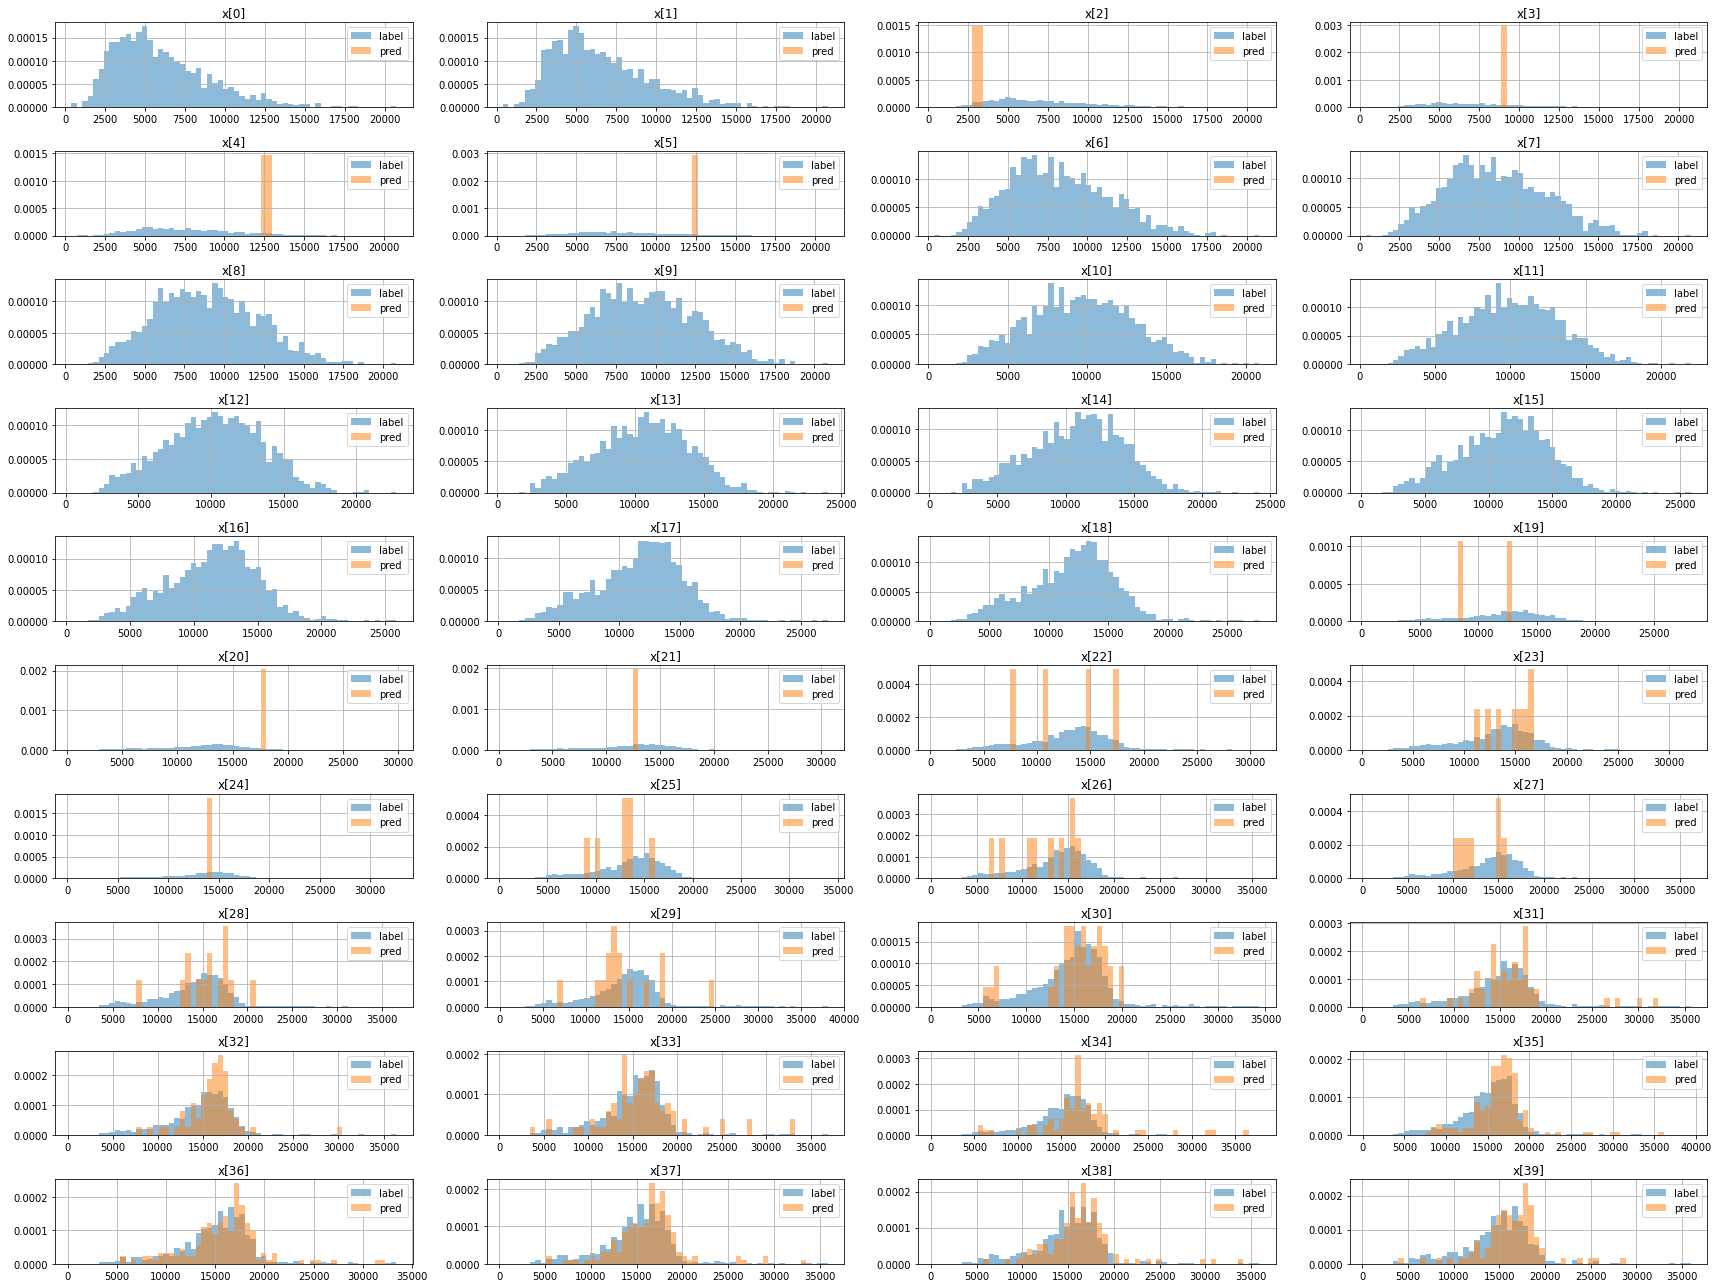

In [44]:
# DEBUG 把最后一个leader去掉
# def debug_fn(row):
#     res = row['leader_atas'].copy()
#     seq_len = row['seq_len']
#     res = [i if idx == seq_len else 0 for idx,i in enumerate(res)]
#     return res
# df['leader_atas_new'] = df.apply(debug_fn, axis=1)

fig,axs = plt.subplots(10,4, figsize=(24,18))
fig.set_tight_layout(True)
axf=axs.flatten()
res_metrics=[]
for i in range(40):
    lbl_i = df['leader_atas'].apply(lambda x: x[i])
    pred_i = df[df['seq_len']==i]['label']
    pred_i
    break
    _=lbl_i.hist(bins=60,density=True,alpha=0.5,label="label",ax=axf[i],range=(400,lbl_i.max()))
    _=pred_i.hist(bins=60,density=True,alpha=0.5,label="pred",ax=axf[i],range=(400,lbl_i.max()))
    _=axf[i].set_title("x[%s]" % i)
    _=axf[i].legend()

plt.show()

#### Features

In [13]:
infos

label_bin
1.0                                  [20210429, 20210430]
2.0     [20210428, 20210427, 20210429, 20210424, 20210...
3.0     [20210425, 20210429, 20210428, 20210425, 20210...
4.0     [20210424, 20210424, 20210427, 20210428, 20210...
5.0     [20210430, 20210427, 20210428, 20210429, 20210...
6.0     [20210430, 20210427, 20210425, 20210429, 20210...
7.0     [20210424, 20210425, 20210429, 20210425, 20210...
8.0     [20210427, 20210428, 20210428, 20210428, 20210...
9.0     [20210428, 20210429, 20210424, 20210425, 20210...
10.0    [20210427, 20210427, 20210427, 20210424, 20210...
11.0    [20210425, 20210427, 20210428, 20210424, 20210...
12.0    [20210425, 20210428, 20210427, 20210430, 20210...
13.0    [20210428, 20210424, 20210425, 20210430, 20210...
14.0    [20210425, 20210427, 20210424, 20210425, 20210...
15.0    [20210424, 20210427, 20210424, 20210425, 20210...
16.0    [20210430, 20210428, 20210427, 20210424, 20210...
17.0    [20210425, 20210425, 20210424, 20210424, 20210...
18.0

,label,pred
count,1560.000000,1560.000000
mean,15995.773077,15160.849840
std,4073.860535,1923.572176
min,2878.000000,4162.213167
25%,14216.000000,14356.295070
50%,16201.000000,15624.987928
75%,17718.750000,16479.366879
max,39395.000000,18935.233622


[2021-06-09 16:11:39-INFO]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-06-09 16:11:39-INFO]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-06-09 16:11:39-INFO]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-06-09 16:11:39-INFO]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-06-09 16:11:39-INFO]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these

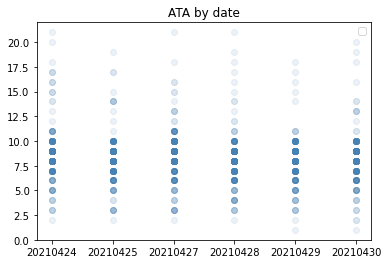

AssertionError: 

In [16]:
hostname="k8s-deploy-ucmlid-1617714052144-fbc9c8495-n2g58"
hostname="map-vrp-data.luban"
city="9_zhengzhou"
# city="17_chengdu"
# city="6_wuhan_1"
df = pd.read_pickle("/nfs/project/zhoutongzt/ETA/ztprivate/gbdt_eta/models/tmp_test_pred_res_%s.pkl.%s" % (city, hostname))
df['label_bin'] = df['label'].apply(lambda x: x//1800.)
df['pred_bin'] = df['pred'].apply(lambda x: x//1800.)
df[['label','pred']].describe()


ax=plt.gca()
infos=df.groupby("date").apply(lambda dfg: dfg["label_bin"].astype(float).tolist())
# ax.scatter(x=np.array(infos.index), y=infos.values)
for k,v in infos.items():
    _=ax.scatter(x=[k]*len(v), y=v,c='steelblue',alpha=0.1)
_ = ax.legend()
_ = ax.set_title("ATA by date")
plt.show()

assert False

Min,Max=df['leader_uid_cnt'].min(),df['leader_uid_cnt'].max()
df['leader_uid_cnt_minmax'] = df['leader_uid_cnt'].apply(lambda x: (x-Min)/(Max-Min))
# Min,Max=df['line_num_sum'].min(),df['line_num_sum'].max()
# df['line_num_sum_minmax'] = df['line_num_sum'].apply(lambda x: (x-Min)/(Max-Min))
# Min,Max=df['first_length'].min(),df['first_length'].max()
# df['first_length_minmax'] = df['first_length'].apply(lambda x: (x-Min)/(Max-Min))


col="leader_uid_cnt_minmax"
ax=plt.gca()
infos=df.groupby("label_bin").apply(lambda dfg: dfg[col].tolist())
# ax.scatter(x=np.array(infos.index), y=infos.values)
for k,v in infos.items():
    _=ax.scatter(x=[k]*len(v), y=v,c='steelblue',alpha=0.1)
_ = ax.plot(infos.index, [np.mean(i) for i in infos.values],label=col)
# _ = ax.plot(infos.index,infos.index, label='label')
_ = ax.legend()
_ = ax.set_title("Test Pred of each Label (bin)")
plt.show()


col="line_num_sum"
ax=plt.gca()
infos=df.groupby("label_bin").apply(lambda dfg: dfg[col].tolist())
# ax.scatter(x=np.array(infos.index), y=infos.values)
for k,v in infos.items():
    _=ax.scatter(x=[k]*len(v), y=v,c='steelblue',alpha=0.1)
_ = ax.plot(infos.index, [np.mean(i) for i in infos.values],label=col)
# _ = ax.plot(infos.index,infos.index, label='label')
_ = ax.legend()
_ = ax.set_title("Test Pred of each Label (bin)")
plt.show()


col="first_length"
ax=plt.gca()
infos=df.groupby("label_bin").apply(lambda dfg: dfg[col].tolist())
# ax.scatter(x=np.array(infos.index), y=infos.values)
for k,v in infos.items():
    _=ax.scatter(x=[k]*len(v), y=v,c='steelblue',alpha=0.1)
_ = ax.plot(infos.index, [np.mean(i) for i in infos.values],label=col)
# _ = ax.plot(infos.index,infos.index, label='label')
_ = ax.legend()
_ = ax.set_title("Test Pred of each Label (bin)")
plt.show()


col="sum"
df['sum'] = df['first_length'] + df['line_num_sum'] + df['leader_uid_cnt_minmax']
ax=plt.gca()
infos=df.groupby("label_bin").apply(lambda dfg: dfg[col].tolist())
# ax.scatter(x=np.array(infos.index), y=infos.values)
for k,v in infos.items():
    _=ax.scatter(x=[k]*len(v), y=v,c='steelblue',alpha=0.1)
_ = ax.plot(infos.index, [np.mean(i) for i in infos.values],label=col)
# _ = ax.plot(infos.index,infos.index, label='label')
_ = ax.legend()
_ = ax.set_title("Test Pred of each Label (bin)")
plt.show()

In [156]:
df[['leader_uid_cnt','uid_feats','label_bin']]

df[df['label_bin'].apply(lambda x: x>=15)]['uid_feats'].shape[0]
df[df['label_bin'].apply(lambda x: x>=15)]['uid_feats'].explode().head(2)
# df[df['uid_feats'].apply(lambda x: any([i in [4149] for i in x]))][['leader_uid_cnt','uid_feats','label_bin']]


,leader_uid_cnt,uid_feats,label_bin
0,36.0,"[4657, 4812, 11622, 12594, 2236, 869, 922, 464...",17.0
1,35.0,"[379, 8357, 4159, 8756, 13372, 6046, 7625, 126...",8.0
2,38.0,"[379, 4159, 2148, 13034, 4150, 8756, 13372, 21...",8.0
3,31.0,"[379, 8756, 8357, 4150, 17901, 132, 19202, 163...",5.0
4,41.0,"[6170, 2180, 5788, 1070, 1578, 2632, -1, 23057...",7.0
...,...,...,...
1597,44.0,"[3711, 3822, 9239, 16159, 7877, 4505, 19897, 2...",7.0
1598,32.0,"[3711, 3822, 9239, 7877, 4505, 5391, 15742, 64...",6.0
1599,35.0,"[15512, 11224, 10464, -1, 9892, 2985, 8575, 96...",19.0
1600,31.0,"[20851, 5100, 11589, 3812, 3858, 14588, 10338,...",10.0


36

0    4657
0    4812
Name: uid_feats, dtype: object

#### RNN

,label,pred
count,1560.000000,1560.000000
mean,15995.773077,14302.012291
std,4073.860535,1301.815803
min,2878.000000,4705.066328
25%,14216.000000,13881.832878
50%,16201.000000,14601.180361
75%,17718.750000,15111.216310
max,39395.000000,16385.828664


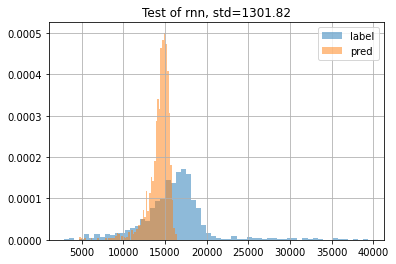

{'count': 1560.0,
 'me': -1693.7607856363497,
 'mae': 2932.546618217432,
 'mape': 0.19140559126398143,
 'badcase': 0.12564102564102564,
 'underrate': 0.732051282051282,
 'overrate': 0.26794871794871794,
 'ata_avg': 15995.773076923067,
 'ata_mid': 16200.999999999989,
 'ata_std': 4072.554600983648,
 'eta_avg': 14302.012291286726,
 'eta_mid': 14601.180360543025,
 'eta_std': 1301.3984877546875}

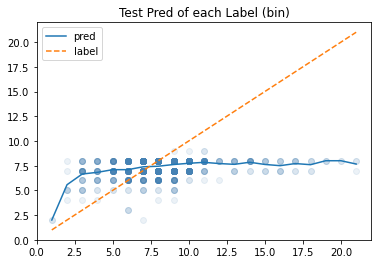

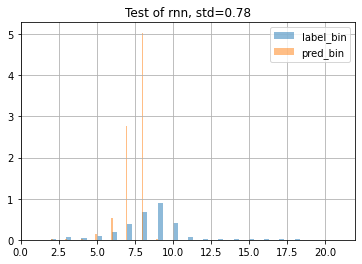

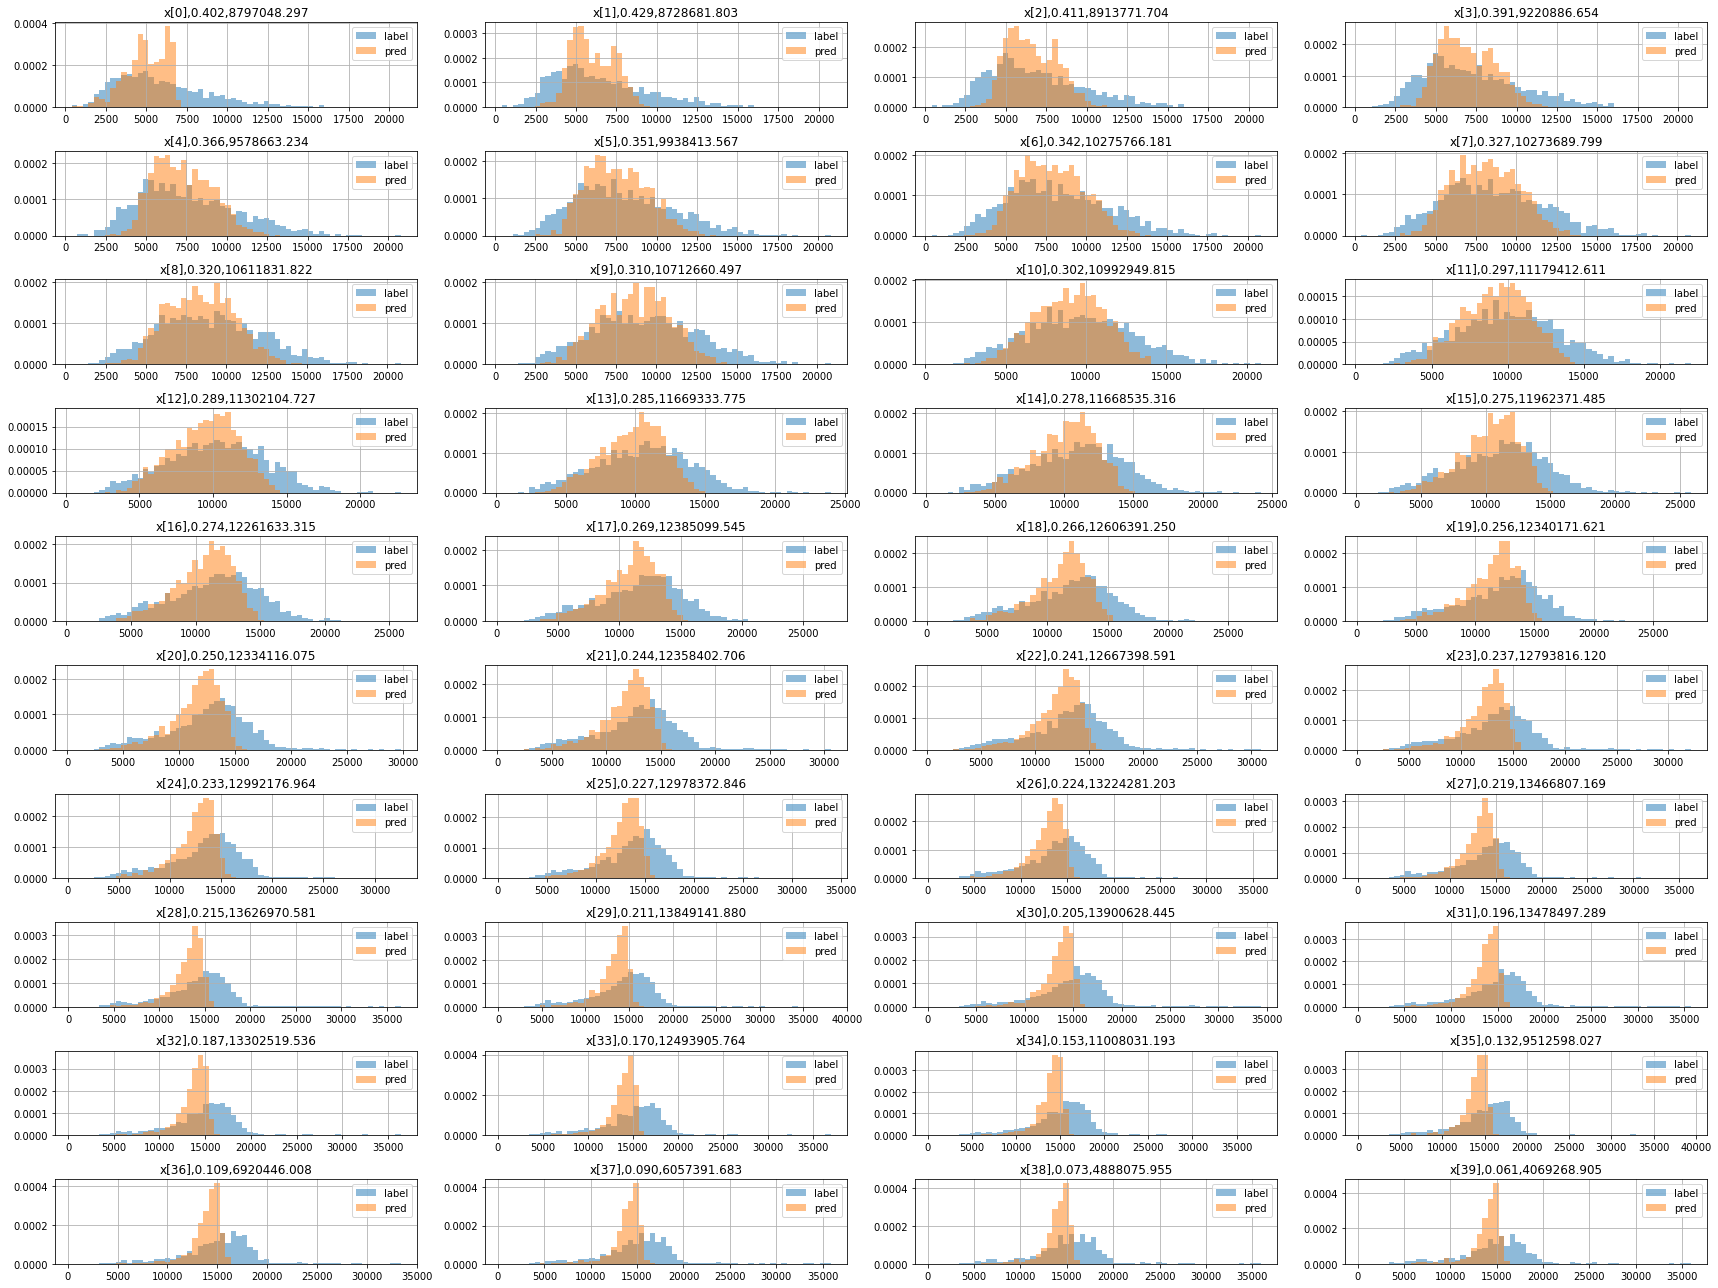

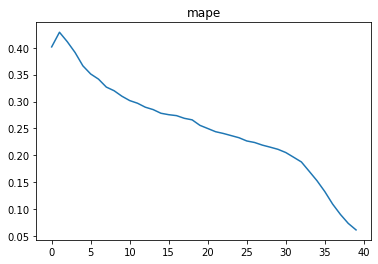

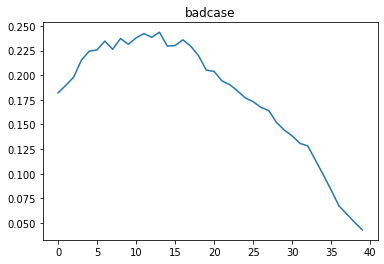

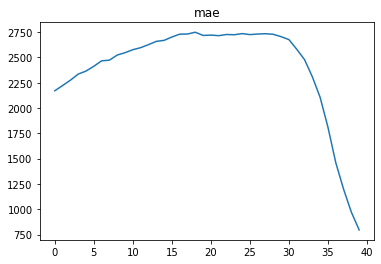

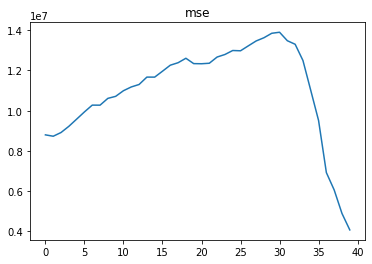

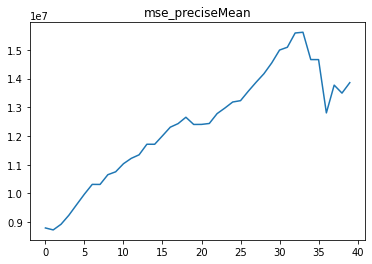

In [7]:
hostname="k8s-deploy-ucmlid-1617714052144-fbc9c8495-n2g58"
# hostname="map-vrp-data.luban"
city="9_zhengzhou"
# city="17_chengdu"
# city="6_wuhan_1"
df = pd.read_pickle("/nfs/project/zhoutongzt/ETA/ztprivate/gbdt_eta/models/tmp_test_pred_res_%s.pkl.%s" % (city, hostname))
df[['label','pred']].describe()

_=df['label'].hist(bins=60,density=True,alpha=0.5,label="label")
_=df['pred'].hist(bins=60,density=True,alpha=0.5,label="pred")
_=plt.legend()
_=plt.title("Test of rnn, std=%.2f" % df['pred'].std())
plt.show()
core.metric(df['label'],df['pred'])


df['label_bin'] = df['label'].apply(lambda x: x//1800)
df['pred_bin'] = df['pred'].apply(lambda x: x//1800)
ax=plt.gca()
infos=df.groupby("label_bin").apply(lambda dfg: dfg['pred_bin'].tolist())
# ax.scatter(x=np.array(infos.index), y=infos.values)
for k,v in infos.items():
    _=ax.scatter(x=[k]*len(v), y=v,c='steelblue',alpha=0.1)
_ = ax.plot(infos.index, [np.mean(i) for i in infos.values],label='pred')
_ = ax.plot(infos.index,infos.index, label='label',linestyle="--")
_ = ax.legend()
_ = ax.set_title("Test Pred of each Label (bin)")
plt.show()

_=df['label_bin'].hist(bins=60,density=True,alpha=0.5,label="label_bin")
_=df['pred_bin'].hist(bins=60,density=True,alpha=0.5,label="pred_bin")
_=plt.legend()
_=plt.title("Test of rnn, std=%.2f" % df['pred_bin'].std())
plt.show()



# df['label_bin'] = df['label'].apply(lambda x: x//1800)
# df['pred_bin'] = df['pred'].apply(lambda x: x//1800)
# _=df['label_bin'].hist(bins=60,density=True,alpha=0.5,label="label_bin")
# _=df['pred_bin'].hist(bins=60,density=True,alpha=0.5,label="pred_bin")
# _=plt.legend()
# plt.show()
# core.metric(df['label_bin'],df['pred_bin'])

# assert False

df['leader_atas'] = df['leader_atas'].apply(lambda x: [math.e**i for i in x])

# 不同index的团长指标和分布
fig,axs = plt.subplots(10,4, figsize=(24,18))
fig.set_tight_layout(True)
axf=axs.flatten()
res_metrics=[]

for i in range(40):
    lbl_i = df['leader_atas'].apply(lambda x: x[i])
    pred_i = df['pred_seq'].apply(lambda x: x[i])
    _=lbl_i.hist(bins=60,density=True,alpha=0.5,label="label",ax=axf[i],range=(400,lbl_i.max()))
    _=pred_i.hist(bins=60,density=True,alpha=0.5,label="pred",ax=axf[i],range=(400,lbl_i.max()))
    res=core.metric(lbl_i, pred_i)
    mse = ((lbl_i - pred_i)**2).mean()
    mse_preciseMean = ((lbl_i - pred_i)**2).sum() / np.nonzero((lbl_i-1).values)[0].shape[0]
    res.update({"mse":mse, "mse_preciseMean":mse_preciseMean})
    res_metrics.append(res)
    _=axf[i].set_title("x[%s],%.3f,%.3f" % (i, res['mape'],mse))
    _=axf[i].legend()

plt.show()

_=plt.plot(range(len(res_metrics)), [i['mape'] for i in res_metrics])
_=plt.title("mape")
plt.show()

_=plt.plot(range(len(res_metrics)), [i['badcase'] for i in res_metrics])
_=plt.title("badcase")
plt.show()

_=plt.plot(range(len(res_metrics)), [i['mae'] for i in res_metrics])
_=plt.title("mae")
plt.show()

_=plt.plot(range(len(res_metrics)), [i['mse'] for i in res_metrics])
_=plt.title("mse")
plt.show()

_=plt.plot(range(len(res_metrics)), [i['mse_preciseMean'] for i in res_metrics])
_=plt.title("mse_preciseMean")
plt.show()

In [22]:
",".join(df[df['label_bin'] > 15.0].apply(lambda row: row['driver_phone_ori']+"_"+row['date'], axis=1).tolist())


'13014676767_1300_20210425,13071000083_6504_20210430,13140171096_4305_20210428,13523442130_1202_20210427,13663853005_1202_20210428,13849038757_1506_20210427,13938291430_2800_20210424,13949039795_3704_20210427,15038393727_6600_20210424,15303729678_3700_20210424,15890083626_1102_20210424,15978415678_5504_20210425,15981961702_7307_20210425,15993319720_1300_20210424,17513222379_5501_20210429,17513222379_5501_20210430,17513222379_7302_20210424,17513228468_4109_20210429,17637815278_1501_20210424,17637815278_1601_20210428,17703836689_4901_20210424,17749413357_1600_20210427,17788121902_3901_20210430,18236955435_6604_20210429,18518989120_4303_20210428,18939250281_7509_20210424,19949272666_1202_20210430,19949272666_5301_20210428'

逐个index查看prediciton和label的差距

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
       19, 20, 23, 25, 26, 28, 31, 32, 33, 34, 36, 38, 39])

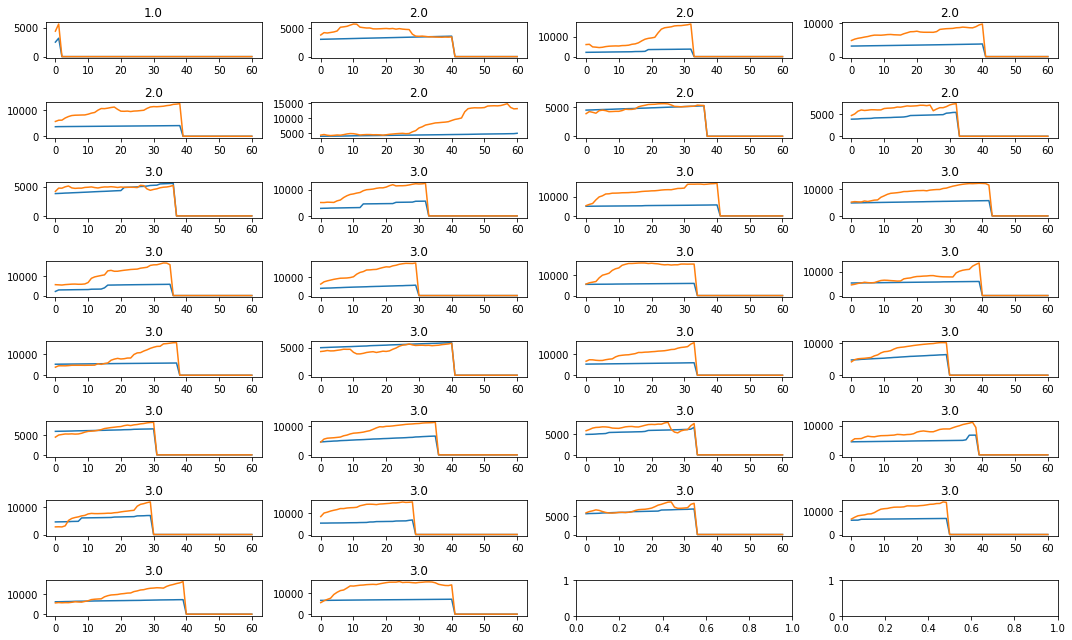

In [124]:
dft = df[df['label_bin'].apply(lambda x: 0<=x<=3)].copy().sort_values("label")
dft['leader_atas'] = dft['leader_atas']#.apply(lambda x: [math.e ** i for i in x])
if dft.shape[0] <= 30:
    idx_list = range(dft.shape[0])
else:
    idx_list = np.random.choice(range(dft.shape[0]),size=30, replace=False)
    idx_list.sort()
    idx_list

fig,axes = plt.subplots(8,4,figsize=(15,9))
_=fig.set_tight_layout(True)
axf=axes.flatten()
for idx,i in enumerate(idx_list):
    ss = dft.iloc[i]
    _=axf[idx].plot(ss['leader_atas'])
    _=axf[idx].plot(ss['pred_seq'])
    _=axf[idx].set_title(ss['label_bin'])
# ",".join(map(str, dft['leader_atas'].apply(lambda x: [math.e**i for i in x]).iloc[0]))
# ",".join(map(str, dft['pred_seq'].iloc[0]))

#### lgb

[2021-06-07 19:36:26-WARNING]: path not exist,dt:20210426 path: /nfs/project/zhoutongzt/ETA/data_parsed_by_line/9_zhengzhou/20210426


,label,pred
count,1872.000000,1872.000000
mean,16017.709936,15846.906418
std,4091.935408,1204.507408
min,3765.000000,8511.336005
25%,14170.500000,15207.003781
50%,16210.000000,16012.871788
75%,17758.500000,16705.471655
max,39395.000000,19271.399929


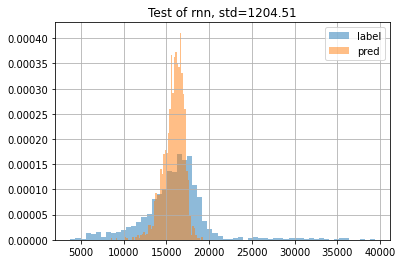

{'count': 1872.0,
 'me': -170.80351766061068,
 'mae': 2368.3253303790557,
 'mape': 0.17177217559790953,
 'badcase': 0.1388888888888889,
 'underrate': 0.5528846153846154,
 'overrate': 0.44711538461538464,
 'ata_avg': 16017.709935897436,
 'ata_mid': 16210.0,
 'ata_std': 4090.8423305012548,
 'eta_avg': 15846.906418236824,
 'eta_mid': 16012.87178847149,
 'eta_std': 1204.185648764841}

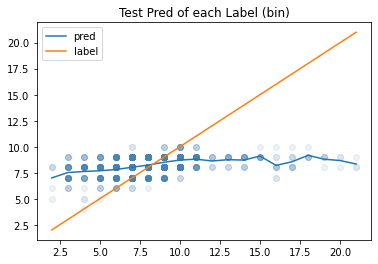

In [157]:
city="9_zhengzhou"
# city="17_chengdu"
M = lgb.Booster(model_file="/nfs/project/zhoutongzt/ETA/%s_model.lgb" % city)
df = load_data(data_dir="/nfs/project/zhoutongzt/ETA/data_parsed_by_line/%s" % city,
                    from_dt="20210423", to_dt="20210430")
df['pred'] = M.predict(df[M.feature_name()])
df[['label','pred']].describe()

_=df['label'].hist(bins=60,density=True,alpha=0.5,label="label")
_=df['pred'].hist(bins=60,density=True,alpha=0.5,label="pred")
_=plt.legend()
_=plt.title("Test of rnn, std=%.2f" % df['pred'].std())
plt.show()
core.metric(df['label'],df['pred'])


df['label_bin'] = df['label'].apply(lambda x: x//1800)
df['pred_bin'] = df['pred'].apply(lambda x: x//1800)
ax=plt.gca()
infos=df.groupby("label_bin").apply(lambda dfg: dfg['pred_bin'].tolist())
# ax.scatter(x=np.array(infos.index), y=infos.values)
for k,v in infos.items():
    _=ax.scatter(x=[k]*len(v), y=v,c='steelblue',alpha=0.1)
_ = ax.plot(infos.index, [np.mean(i) for i in infos.values],label='pred')
_ = ax.plot(infos.index,infos.index, label='label')
_ = ax.legend()
_ = ax.set_title("Test Pred of each Label (bin)")
plt.show()

### Train

,label,pred
count,13183.000000,13183.000000
mean,15099.955776,14005.896453
std,4685.994205,2277.750682
min,1454.000000,3780.252053
25%,12738.500000,12809.361108
50%,15127.000000,14503.948599
75%,17170.000000,15708.612637
max,39968.000000,17763.848581


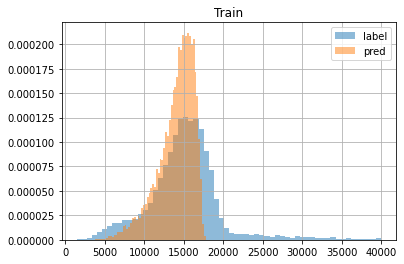

{'count': 13183.0,
 'me': -1094.0593229204733,
 'mae': 2518.7003946709187,
 'mape': 0.17347266038577294,
 'badcase': 0.12197527118258362,
 'underrate': 0.619206553895168,
 'overrate': 0.38079344610483196,
 'ata_avg': 15099.955776378663,
 'ata_mid': 15127.000000000002,
 'ata_std': 4685.8164728665315,
 'eta_avg': 14005.896453458186,
 'eta_mid': 14503.948598805719,
 'eta_std': 2277.664290590094}

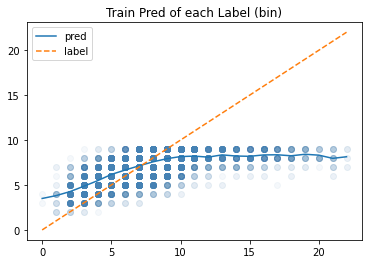

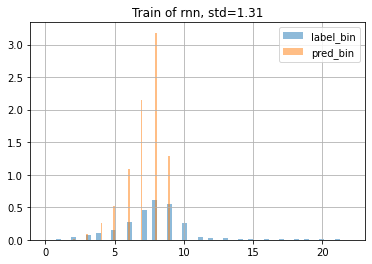

{'count': 13183.0,
 'me': -1094.0593229204733,
 'mae': 2518.7003946709187,
 'mape': 0.17347266038577294,
 'badcase': 0.12197527118258362,
 'underrate': 0.619206553895168,
 'overrate': 0.38079344610483196,
 'ata_avg': 15099.955776378663,
 'ata_mid': 15127.000000000002,
 'ata_std': 4685.8164728665315,
 'eta_avg': 14005.896453458186,
 'eta_mid': 14503.948598805719,
 'eta_std': 2277.664290590094}

In [9]:
hostname="k8s-deploy-ucmlid-1617714052144-fbc9c8495-n2g58"
# hostname="map-vrp-data.luban"
city="9_zhengzhou"
# city="17_chengdu"
# city="6_wuhan_1"
df = pd.read_pickle("/nfs/project/zhoutongzt/ETA/ztprivate/gbdt_eta/models/tmp_train_pred_res_%s.pkl.%s" % (city,hostname))
df['leader_atas'] = df['leader_atas'].apply(lambda x: [math.e**i for i in x])
df[['label','pred']].describe()

_=df['label'].hist(bins=60,density=True,alpha=0.5,label="label")
_=df['pred'].hist(bins=60,density=True,alpha=0.5,label="pred")
_=plt.legend()
_ = plt.title("Train")
plt.show()
core.metric(df['label'],df['pred'])

df['label_bin'] = df['label'].apply(lambda x: x//1800)
df['pred_bin'] = df['pred'].apply(lambda x: x//1800)
ax=plt.gca()
infos=df.groupby("label_bin").apply(lambda dfg: dfg['pred_bin'].tolist())
# ax.scatter(x=np.array(infos.index), y=infos.values)
for k,v in infos.items():
    _=ax.scatter(x=[k]*len(v), y=v,c='steelblue',alpha=0.05)
_ = ax.plot(infos.index, [np.mean(i) for i in infos.values],label='pred')
_ = ax.plot(infos.index,infos.index, label='label',linestyle="--")
# _ = ax.plot(infos.index,infos.index+1, linestyle="--",c="orange")
# _ = ax.plot(infos.index,infos.index-1, linestyle="--",c="orange")
_ = ax.legend()
_ = ax.set_title("Train Pred of each Label (bin)")
plt.show()

_=df['label_bin'].hist(bins=60,density=True,alpha=0.5,label="label_bin")
_=df['pred_bin'].hist(bins=60,density=True,alpha=0.5,label="pred_bin")
_=plt.legend()
_=plt.title("Train of rnn, std=%.2f" % df['pred_bin'].std())
plt.show()

# df['label_bin'] = df['label'].apply(lambda x: x//1800)
# df['pred_bin'] = df['pred'].apply(lambda x: x//1800)
# _=df['label_bin'].hist(bins=60,density=True,alpha=0.5,label="label_bin")
# _=df['pred_bin'].hist(bins=60,density=True,alpha=0.5,label="pred_bin")
# _=plt.legend()
# plt.show()
core.metric(df['label'],df['pred'])



In [37]:
core.get_dates("20210426","20210426")

['20210426']

In [3]:
city="9_zhengzhou"
fromDt,toDt="20210423","20210430"
self = core.DataFetcher()
df = self._load_explode_data(city, fromDt, toDt)
# df = self._add_extra_cols(df)
inpDF=df
for keys, dfg in tqdm(inpDF.groupby(["driver_phone_ori", "date"])):
#     break
    for col in ['store_type', "leader_age", "sku_cnt", "num_sum"]:
        dfg[col + "_25q"] = np.percentile(dfg[col + "_str"].astype(int), 25)
        dfg[col + "_50q"] = np.percentile(dfg[col + "_str"].astype(int), 50)
        dfg[col + "_75q"] = np.percentile(dfg[col + "_str"].astype(int), 75)

# np.percentile(dfg['leader_age_str'],25)
# dfg['leader_age_str'].dtype
# dfg['store_type_str'].dtype
        

[2021-06-08 15:46:57-INFO]:   _load_explode_data


  0%|          | 0/1871 [00:00<?, ?it/s]

In [74]:
df.dtypes
(df.replace("None","-1")['leader_age_str'] == "None").sum()
(df['leader_age_str'] == "None").sum()

driver_phone_ori         object
date                      int64
ata                       int64
leader_uid_cnt          float64
line_num_sum            float64
fruits_count            float64
vgtble_count            float64
fresh_count             float64
category_id_count         int64
refrigeration_type_0    float64
refrigeration_type_1    float64
refrigeration_type_2    float64
refrigeration_type_3    float64
uid_str                   int64
leader_age_str           object
leader_sex_num_str        int64
store_type_str            int64
has_store_id_str          int64
is_td_new_leader          int64
is_month_new_leader       int64
delivery_id_str           int64
num_sum_str               int64
sku_cnt_str               int64
user_cnt_str              int64
rp_eta                    int64
rp_length                 int64
leader_ata                int64
trans_index               int64
label                     int64
dtype: object

0

1

In [66]:
[df[col].apply(lambda x: x=="None").sum() for col in df.columns]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [68]:
(df['leader_age_str'] == "None").sum()
dfg['leader_age_str'] == "None"

1

8775    False
8776    False
8777    False
8778    False
8779    False
8780    False
8781    False
8782    False
8783    False
8784    False
8785    False
8786    False
8787    False
8788    False
8789     True
8790    False
8791    False
8792    False
8793    False
8794    False
8795    False
8796    False
8797    False
8798    False
8799    False
8800    False
8801    False
8802    False
8803    False
8804    False
8805    False
8806    False
8807    False
8808    False
8809    False
Name: leader_age_str, dtype: bool

In [61]:
dfg[['store_type_str', "leader_age_str", "sku_cnt_str", "num_sum_str"]]

,store_type_str,leader_age_str,sku_cnt_str,num_sum_str
8775,50,51,30,35
8776,1,42,19,22
8777,50,44,1,1
8778,50,47,9,9
8779,50,26,5,7
8780,2,32,4,4
8781,50,42,1,1
8782,50,24,1,1
8783,2,32,1,1
8784,50,38,1,1


In [39]:
_date="20210428"
data_fp=["/nfs/project/zhoutongzt/ETA/data/9_zhengzhou/20210428/part-00000"]
cols = ["driver_phone_ori","leader_age_str","leader_sex_num_str","store_type_str","has_store_id_str","is_td_new_leader","is_month_new_leader","delivery_id_str","num_sum_str","sku_cnt_str","user_cnt_str","gmv_str","leader_uid_cnt_str","line_num_sum_str","line_gmv_str","tocar_time_str","max_action_time_str","good_item_str","uid_str","eta_str"]
loadDF = pd.concat([pd.read_csv(fp, sep=";;", header=None, names=cols, engine='python') for fp in data_fp])


def filter_func(line):
    driver_phone_ori, leader_age_str, leader_sex_num_str, store_type_str, has_store_id_str, is_td_new_leader, is_month_new_leader, delivery_id_str, num_sum_str, \
    sku_cnt_str, user_cnt_str, gmv_str, leader_uid_cnt_str, line_num_sum_str, line_gmv_str, tocar_time_str, max_action_time_str, \
    good_item_str, uid_str, eta_str = line

    conds = list()
    # conds.append(len(uid_str.split(",")) == int(leader_uid_cnt_str.split(",")[0]))
    conds.append(len(max_action_time_str.split(",")) == len(eta_str.split(",")))
    leaderFeats = [leader_age_str, leader_sex_num_str, store_type_str, has_store_id_str, is_td_new_leader,
                   is_month_new_leader, delivery_id_str, delivery_id_str, num_sum_str, sku_cnt_str, user_cnt_str,
                   gmv_str, max_action_time_str]
    conds.append(len(set([len(f.split(",")) for f in leaderFeats])) == 1)
    return all(conds)
loadDF = loadDF[loadDF.apply(filter_func, axis=1)]


res = []
for idx, line in loadDF.iterrows():
    driver_phone_ori, leader_age_str, leader_sex_num_str, store_type_str, has_store_id_str, is_td_new_leader, is_month_new_leader, delivery_id_str, num_sum_str, \
    sku_cnt_str, user_cnt_str, gmv_str, leader_uid_cnt_str, line_num_sum_str, line_gmv_str, tocar_time_str, max_action_time_str, \
    good_item_str, uid_str, eta_str = line
    try:
        # 线维度，公有特征的处理
        leader_uid_cnt = float(leader_uid_cnt_str.split(",")[0])
        line_num_sum = float(line_num_sum_str.split(",")[0])
        line_gmv = float(line_gmv_str.split(",")[0])
        tocar_time = tocar_time_str.split(",")[0]
        good_item_list = good_item_str.split(",")
        # ATA解析
        leader_ata = [datetime.strptime(t, "%Y-%m-%d %H:%M:%S") - datetime.strptime(tocar_time, "%Y-%m-%d %H:%M:%S")
                    for t in max_action_time_str.split(",")]
        leader_ata = [i.seconds for i in leader_ata]
        line_ata = max(leader_ata)

        # RP_ETA解析
        # eta_str存的是配送顺序，但是max_action_time包括其他都不是配送顺序，重排后拿到配送index下各个item的原始index
        assert len(max_action_time_str.split(",")) == len(eta_str.split(","))
        oriIndex = [i[0] for i in sorted(enumerate(max_action_time_str.split(",")), key=lambda x: x[1])]
        eta_str_oriIndex = [i[1] for i in sorted(zip(oriIndex, eta_str.split(",")), key=lambda x: x[0])]
        # 注意最后按trans_index重新排序得到配送顺序
        trans_index = [i.split("_")[0] for i in eta_str_oriIndex]
        rp_eta = [i.split("_")[1] for i in eta_str_oriIndex]
        rp_length = [i.split("_")[2] for i in eta_str_oriIndex]

        # 其他特征直接逗号分隔
        leaderFeats = [leader_age_str, leader_sex_num_str, store_type_str, has_store_id_str, is_td_new_leader,is_month_new_leader,delivery_id_str,num_sum_str,sku_cnt_str,user_cnt_str,gmv_str]
        allFeats = [feat.split(",") for feat in leaderFeats] + [rp_eta, rp_length, leader_ata, trans_index]
        allFeats = np.vstack(allFeats).T.astype(float)
        allFeats = np.hstack([np.array(uid_str.split(",")).reshape((-1,1)),allFeats])  # 组装uid
        allFeats = np.array(sorted(allFeats, key=lambda x: float(x[-1])))   # 按每行的最后一个元素trans_index排序拿到实际配送顺序下的样本序列


        line_features = [driver_phone_ori, _date, line_ata, leader_uid_cnt, line_num_sum, line_gmv] + good_item_list
        concatFeats = [line_features + list(feats) for feats in allFeats]
        res.extend(concatFeats)
    except Exception as e:
        logging.error("err when parsing. %s %s %s" % (driver_phone_ori, _date, str(e)))
    break


## data_parse

In [3]:
%%time

self = core.DataFetcher()

df = self._load_explode_data("9_zhengzhou", "20210301", "20210314")
logging.info(">>> head(3): \n%s" % str(df.head(3)))
df = self._add_extra_cols(df)
logging.info(">>> head(3): \n%s" % str(df.head(3)))

[2021-06-09 12:04:07-INFO]:   _load_explode_data
[2021-06-09 12:04:07-INFO]: >>> head(3): 
   driver_phone_ori      date    ata  leader_uid_cnt  line_num_sum  \
0       18439472966  20210301  10829            35.0         659.0   
1       18439472966  20210301  10829            35.0         659.0   
2       18439472966  20210301  10829            35.0         659.0   

   fruits_count  vgtble_count  fresh_count  category_id_count  \
0         190.0         821.0       1302.0                 16   
1         190.0         821.0       1302.0                 16   
2         190.0         821.0       1302.0                 16   

   refrigeration_type_0  refrigeration_type_1  refrigeration_type_2  \
0                1603.0                 100.0                 149.0   
1                1603.0                 100.0                 149.0   
2                1603.0                 100.0                 149.0   

   refrigeration_type_3             uid_str  leader_age_str  \
0                  

  0%|          | 0/3031 [00:00<?, ?it/s]

[2021-06-09 12:05:03-INFO]: >>> head(3): 
      driver_phone_ori      date   ata  leader_uid_cnt  line_num_sum  \
2122       13007513313  20210301  6157            34.0         807.0   
2123       13007513313  20210301  6157            34.0         807.0   
2124       13007513313  20210301  6157            34.0         807.0   

      fruits_count  vgtble_count  fresh_count  category_id_count  \
2122         234.0         910.0       1416.0                 15   
2123         234.0         910.0       1416.0                 15   
2124         234.0         910.0       1416.0                 15   

      refrigeration_type_0  refrigeration_type_1  refrigeration_type_2  \
2122                1866.0                 132.0                 138.0   
2123                1866.0                 132.0                 138.0   
2124                1866.0                 132.0                 138.0   

      refrigeration_type_3             uid_str  leader_age_str  \
2122                  17.0  63924

CPU times: user 55.3 s, sys: 1.46 s, total: 56.7 s
Wall time: 56.1 s


parallel

In [2]:
%%time
from joblib import Parallel, delayed
self = core.DataFetcher()

df = self._load_explode_data("9_zhengzhou", "20210301", "20210314")

def group_fn(inpDF):
    line_num_sum = inpDF['line_num_sum'].iloc[0]
    res = []
    for keys, dfg in inpDF.groupby(["driver_phone_ori", "date"]):
        dfg = dfg.sort_values("trans_index")
        line_num_sum = dfg['line_num_sum'].iloc[0]
        num_sum_cur = dfg['num_sum_str'].tolist()
        dfg['num_sum_remain'] = dfg.apply(lambda row:
                                          line_num_sum - sum(num_sum_cur[:int(row['trans_index'])]), axis=1)
        # 线层面全局特征 | 商品特征已在 data_parse 时加入
        dfg['line_sku_cnt'] = dfg['sku_cnt_str'].sum()
        first_rp_eta = dfg['rp_eta'].iloc[0]
        first_rp_length = dfg['rp_length'].iloc[0]
        dfg['leader_eta'] = dfg['rp_eta'].sum() - first_rp_eta
        dfg['leader_length'] = dfg['rp_length'].sum() - first_rp_length
        dfg['first_eta'] = first_rp_eta
        dfg['first_length'] = first_rp_length
        dfg['is_td_new_count'] = dfg['is_td_new_leader'].tolist().count(1)
        dfg['is_month_new_leader_count'] = dfg['is_month_new_leader'].tolist().count(1)
        for col in ['store_type', "leader_age", "sku_cnt", "num_sum"]:
            ss = dfg[col + "_str"].astype(float)
            dfg[col + "_25q"] = np.percentile(ss, 25)
            dfg[col + "_50q"] = np.percentile(ss, 50)
            dfg[col + "_75q"] = np.percentile(ss, 75)
        res.append(dfg)
    return pd.concat(res)
    
resDF = pd.concat(Parallel(n_jobs=-1)(delayed(group_fn)(group) for _, group in df.groupby("date")))


resDF.sort_values(["driver_phone_ori","date"]).head(3)
resDF.shape
df.sort_values(["driver_phone_ori","date"]).head(3)
df.shape

[2021-06-09 12:03:30-INFO]:   _load_explode_data


CPU times: user 636 ms, sys: 447 ms, total: 1.08 s
Wall time: 14.3 s


(99550, 29)

### parallelV2

In [5]:
%%time
from joblib import Parallel, delayed
self = core.DataFetcher()

df = self._load_explode_data("9_zhengzhou", "20210301", "20210314")

def group_fn(dfg):
    dfg = dfg.sort_values("trans_index")
    line_num_sum = dfg['line_num_sum'].iloc[0]
    num_sum_cur = dfg['num_sum_str'].tolist()
    dfg['num_sum_remain'] = dfg.apply(lambda row:
                                      line_num_sum - sum(num_sum_cur[:int(row['trans_index'])]), axis=1)
    # 线层面全局特征 | 商品特征已在 data_parse 时加入
    dfg['line_sku_cnt'] = dfg['sku_cnt_str'].sum()
    first_rp_eta = dfg['rp_eta'].iloc[0]
    first_rp_length = dfg['rp_length'].iloc[0]
    dfg['leader_eta'] = dfg['rp_eta'].sum() - first_rp_eta
    dfg['leader_length'] = dfg['rp_length'].sum() - first_rp_length
    dfg['first_eta'] = first_rp_eta
    dfg['first_length'] = first_rp_length
    dfg['is_td_new_count'] = dfg['is_td_new_leader'].tolist().count(1)
    dfg['is_month_new_leader_count'] = dfg['is_month_new_leader'].tolist().count(1)
    for col in ['store_type', "leader_age", "sku_cnt", "num_sum"]:
        ss = dfg[col + "_str"].astype(float)
        dfg[col + "_25q"] = np.percentile(ss, 25)
        dfg[col + "_50q"] = np.percentile(ss, 50)
        dfg[col + "_75q"] = np.percentile(ss, 75)
    return dfg

resDF = pd.concat(Parallel(n_jobs=-1)(delayed(group_fn)(group) for _, group in df.groupby(["driver_phone_ori","date"])))


resDF.sort_values(["driver_phone_ori","date"]).head(3)
resDF.shape
df.sort_values(["driver_phone_ori","date"]).head(3)
df.shape

[2021-06-09 12:10:44-INFO]:   _load_explode_data


CPU times: user 28.4 s, sys: 1.44 s, total: 29.8 s
Wall time: 31.2 s


(99550, 29)

## Oversample

### mock

In [ ]:
# [df[df['label'] > np.percentile(df['label'], 95)]]*10
city="9_zhengzhou"
city
df = pd.read_pickle("/nfs/project/zhoutongzt/ETA/ztprivate/gbdt_eta/models/%s_train.pkl" % city)

bins,holds=np.histogram(df['label'], bins=60)
cnt_mean = np.mean(bins)
bins
holds
cnt_mean
res=[df]
for l,r,cnt in zip(holds[:-1],holds[1:],bins):
    res.extend([df[df['label'].apply(lambda x: l<=x<=r)]]* int(2* cnt_mean/(cnt+1)))
resDF=pd.concat(res, ignore_index=True)

_=df['label'].hist(bins=60)
plt.show()

_=resDF['label'].hist(bins=60)
plt.show()

### direct usage

'9_zhengzhou'

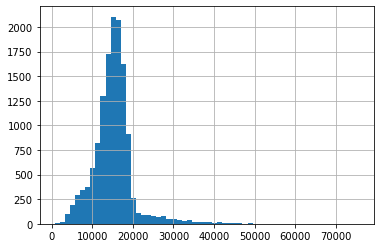

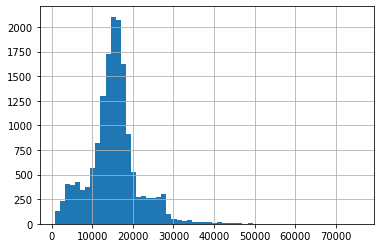

In [12]:
city="9_zhengzhou"
city
trainDF = pd.read_pickle("/nfs/project/zhoutongzt/ETA/ztprivate/gbdt_eta/models/%s_train.pkl" % city)

trainDF_os = core.data.over_sample(trainDF, scale=1, bins=40, _range=(0, 8*3600))


_=trainDF['label'].hist(bins=60)
plt.show()

_=trainDF_os['label'].hist(bins=60)
plt.show()

## mock

In [93]:
from RNNDemo_seqLoss_addLineFeats import *

In [94]:
city="9_zhengzhou"
fetcher = DataFetcher()

logging.info(">>> loading train/test from pickle")
trainDF = type_format(pd.read_pickle("/nfs/project/zhoutongzt/ETA/ztprivate/gbdt_eta/models/%s_train.pkl" % city))
testDF = type_format(pd.read_pickle("/nfs/project/zhoutongzt/ETA/ztprivate/gbdt_eta/models/%s_test.pkl" % city))
logging.info(">>> special_check")
trainDF = special_check(trainDF, city)
testDF = special_check(testDF, city)


trainDF = core.data.pad_leaders(trainDF)
testDF = core.data.pad_leaders(testDF)
lbl_trans_forward = lambda x: math.log(x) if x > 0 else 0  # pad leader_atas 会有0
lbl_trans_backward = lambda x: math.e ** x

trainDF['leader_atas'] = trainDF['leader_atas'].apply(lambda x: [lbl_trans_forward(i) for i in x])
testDF['leader_atas'] = testDF['leader_atas'].apply(lambda x: [lbl_trans_forward(i) for i in x])
trainDF['label'] = trainDF['label'].apply(lbl_trans_forward)
testDF['label'] = testDF['label'].apply(lbl_trans_forward)

trainDF['sample_weight'] = 1.0
testDF['sample_weight'] = 1.0

def add_seq_weight(row, all_ones=False):
    base_w = np.ones_like(row['leader_atas'])
    if all_ones:
        return base_w
    else:
        base_w[0] = 20
        base_w[row['seq_len']-1] = 20
        return base_w
trainDF['seq_weights'] = trainDF.apply(add_seq_weight, axis=1)
testDF['seq_weights'] = testDF.apply(lambda x: add_seq_weight(x, all_ones=True), axis=1)
rnn_params = {
    "batch_size": 128,
    "epoch": 32,
    "mlp_hidden_size": [32],
    "rnn_hidden_size": [16],
    "opt_lr": 1e-2,
    "clip_min": -1e4,
    "clip_max": 1e4,
    "eval_step": 500,
    "log_step_count_steps": 500,
    "cat_num_buckets": 100,
    "emb_num_buckets": 25*1000,
    "emb_size": 16,
}

# 线维度特征处理
trainDF["line_num_feats"] = trainDF.apply(lambda row: [row[i] for i in LINE_FEAT_COLS], axis=1)
testDF["line_num_feats"] = testDF.apply(lambda row: [row[i] for i in LINE_FEAT_COLS], axis=1)
# line_logits只用来计算了最后一个leader的ETA，为了能和preds相加，前面后面都得mask掉
def make_mask(row,pad_size):
    zeros=np.zeros(pad_size)
    zeros[row['seq_len']-1]=1
    return zeros
pad_size = trainDF["cat_feats"].apply(len).max()
trainDF['line_mask'] = trainDF.apply(lambda row: make_mask(row,pad_size), axis=1)
pad_size = testDF["cat_feats"].apply(len).max()
testDF['line_mask'] = testDF.apply(lambda row: make_mask(row,pad_size), axis=1)



def get_shape_dict(inpDF):
    pad_size = inpDF["cat_feats"].apply(lambda x: len(x)).max()
    shape_dict_common = {
        "driver_phone_ori": (),
        "date": (),
        "label": (),
        "seq_len": (),
        "sample_weight": (),
        "leader_uid_cnt": (),
        "line_num_feats": (len(LINE_FEAT_COLS),),
    }
    shape_dict_train = {
        "cat_feats": (pad_size, len(CAT_COLS)),
        "num_feats": (pad_size, len(NUM_COLS)),
        "uid_feats": (pad_size,),
        "leader_atas": (pad_size,),
        "seq_weights": (pad_size,),
        "line_mask": (pad_size,),
        "leader_index": (pad_size,),
    }
    shape_dict = {**shape_dict_train, **shape_dict_common}
    return shape_dict

typeDict = {"driver_phone_ori": tf.string,
            "date": tf.string,
            "leader_uid_cnt": tf.float16,
            "label": tf.float32,
            "cat_feats": tf.int32,
            "num_feats": tf.float32,
            "uid_feats": tf.int32,
            "seq_len": tf.int32,
            "sample_weight": tf.float32,
            "leader_atas": tf.float32,
            "seq_weights": tf.float32,
            "line_num_feats": tf.float32,
            "line_mask": tf.float32,
            "leader_index": tf.float32,
            }
shapeDict_train = get_shape_dict(trainDF)
shapeDict_test = get_shape_dict(testDF)

rnn = RNNDemo(tbd_fp="./tbd_info", tbd_freq=5, **rnn_params)
features, labels = rnn.parse_from_df(trainDF, batch_size=rnn.batch_size, epoch=rnn.epoch,
                                      _typeDict=typeDict, _shapeDict=shapeDict_train,
                                      mode="train")





[2021-06-07 15:04:30-INFO]: >>> loading train/test from pickle
[2021-06-07 15:04:31-INFO]: >>> special_check
[2021-06-07 15:04:31-INFO]:     确保leader_atas是递增的: 13593 --> 13513
[2021-06-07 15:04:42-INFO]:     根据tocar_time的轨迹进行过滤: 13513 --> 13245
[2021-06-07 15:04:42-INFO]:     确保leader_atas是递增的: 1605 --> 1598
[2021-06-07 15:04:43-INFO]:     根据tocar_time的轨迹进行过滤: 1598 --> 1563
[2021-06-07 15:04:43-INFO]: >>> max pad_size: 84
[2021-06-07 15:04:45-INFO]: >>> max pad_size: 61
[2021-06-07 15:04:49-INFO]: >>> kwargs: {'opt_lr': 0.01, 'clip_min': -10000.0, 'clip_max': 10000.0, 'eval_step': 500, 'log_step_count_steps': 500}


In [95]:
calc_res=rnn.calc(features,"EXP")
outputs=calc_res[0]
pred_seq=calc_res[-1]
lbl_seq = features['leader_atas']
seq_len = features['seq_len']
seq_mask = tf.sequence_mask(features['seq_len'], maxlen=tf.shape(features['num_feats'])[1], dtype=tf.float32)
pred_seq_masked = tf.math.multiply(tf.squeeze(pred_seq), seq_mask)
last_pred=core.get_last_of_seq(pred_seq_masked, seq_len)
last_lbl=core.get_last_of_seq(lbl_seq, seq_len)




"outputs",outputs
"pred_seq",pred_seq
"line_num_feats",features['line_num_feats']
"line_mask",features['line_mask']
"leader_index",features['leader_index']

line_logits=tf.layers.dense(features['line_num_feats'], 1)
# line_logits=tf.expand_dims(tf.layers.dense(line_logits, 1), axis=1)
# "line_logits",line_logits
# line_logits = line_logits * tf.ones((1, tf.shape(preds)[1])) * features['line_mask']
# line_logits = tf.expand_dims(line_logits, axis=2)
# "line_logits",line_logits


"seq_mask",seq_mask
"pred_seq_masked",pred_seq_masked

('outputs',
 <tf.Tensor 'rnn/rnn/transpose_1:0' shape=(?, 84, 16) dtype=float32>)

('pred_seq',
 <tf.Tensor 'pred_mlp/predictions/Identity:0' shape=(?, 84, 1) dtype=float32>)

('line_num_feats', <tf.Tensor 'IteratorGetNext:7' shape=(?, 28) dtype=float32>)

('line_mask', <tf.Tensor 'IteratorGetNext:6' shape=(?, 84) dtype=float32>)

('leader_index', <tf.Tensor 'IteratorGetNext:4' shape=(?, 84) dtype=float32>)

('seq_mask', <tf.Tensor 'SequenceMask/Cast_1:0' shape=(?, ?) dtype=float32>)

('pred_seq_masked', <tf.Tensor 'Mul:0' shape=<unknown> dtype=float32>)

### mape loss

In [107]:

mape_each = tf.math.multiply(tf.abs(pred_seq_masked - lbl_seq), 1/(lbl_seq+1e-10))
mape_batch = tf.reduce_mean(mape_each, axis=1)
mape_batch = tf.multiply(tf.reduce_sum(mape_each, axis=1), 1 / tf.cast(seq_len, tf.float32))

In [108]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    res=sess.run([mape_each, mape_batch])

### order_loss

In [87]:
order_loss_each = pred_seq_masked[:, :-1] - pred_seq_masked[:, 1:]
order_loss_each = tf.nn.relu(order_loss_each)
# 首位填充0，保持长度和pred_seq、label_seq一样，方便后面做mask
order_loss_each = tf.concat([tf.zeros((tf.shape(order_loss_each)[0], 1)), order_loss_each], axis=1)
# 错位相减会出现最后一个团长的pred被padding的0给减了一下，这个要mask掉 i.e. [1,2,3,0,0] -> [2,3,0,0] - [1,2,3,0] = [1,1,-3,0]
seq_mask = tf.sequence_mask(seq_len, maxlen=tf.shape(pred_seq_masked)[1], dtype=tf.float32)
order_loss_each = tf.multiply(order_loss_each, seq_mask)

loss_each = tf.square(pred_seq_masked - lbl_seq)
# loss_each = tf.math.multiply(loss_each, order_loss_each)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    
    res=sess.run([pred_seq_masked, order_loss_each, loss_each, order_weight_each])



In [88]:
for i in res:
    i.shape
    
res[0]
res[1]
res[2]
res[3]

(128, 84)

(128, 84)

(128, 84)

(2, 5)

array([[-0.14252812, -0.27519196, -0.3757478 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.18114325, -0.25573057, -0.3105263 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.18717313, -0.27078602, -0.3714475 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.18819165, -0.3161968 , -0.42369515, ...,  0.        ,
         0.        ,  0.        ],
       [-0.177338  , -0.29720858, -0.3479437 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.12139715, -0.20654407, -0.12788646, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

array([[0.        , 0.13266385, 0.10055584, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.07458732, 0.05479574, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.08361289, 0.10066149, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.12800515, 0.10749835, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.11987057, 0.05073512, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.08514693, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

array([[77.363464, 79.78637 , 81.65246 , ...,  0.      ,  0.      ,
         0.      ],
       [72.039604, 73.39149 , 77.04042 , ...,  0.      ,  0.      ,
         0.      ],
       [74.31012 , 75.811615, 77.62426 , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [79.22694 , 81.66707 , 83.68412 , ...,  0.      ,  0.      ,
         0.      ],
       [88.899025, 91.86994 , 93.19188 , ...,  0.      ,  0.      ,
         0.      ],
       [80.348145, 82.012184, 80.66314 , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

array([[1., 1., 1., 4., 1.],
       [1., 2., 1., 4., 1.]], dtype=float32)

In [80]:
testP=[[1.,2.,3.,0.,0.],
       [2.,1.,3.,0.,0.]]
test_seq_len=[3,3]
testP = tf.convert_to_tensor(testP)
test_seq_len=tf.convert_to_tensor(test_seq_len)
seq_mask = tf.sequence_mask(test_seq_len, maxlen=tf.shape(testP)[1], dtype=tf.float32)

order_loss_each = testP[:, 1:] - testP[:, :-1]
order_loss_each = tf.nn.relu(-1 * order_loss_each)
order_loss_each = tf.concat([tf.zeros((tf.shape(order_loss_batch)[0], 1)), order_loss_each], axis=1)
_order_loss_each = tf.multiply(order_loss_each,seq_mask)
order_loss_batch = tf.reduce_mean(order_loss_each, axis=1)
order_loss_weight = order_loss_each+1


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    res = sess.run([testP,order_loss_each,seq_mask,_order_loss_each])

In [81]:
for i in res:
    i.shape
    
res[0]
res[1]
res[2]
res[3]

(2, 5)

(2, 5)

(2, 5)

(2, 5)

array([[1., 2., 3., 0., 0.],
       [2., 1., 3., 0., 0.]], dtype=float32)

array([[ 0.,  0.,  0.,  3., -0.],
       [ 0.,  1.,  0.,  3., -0.]], dtype=float32)

array([[1., 1., 1., 0., 0.],
       [1., 1., 1., 0., 0.]], dtype=float32)

array([[ 0.,  0.,  0.,  0., -0.],
       [ 0.,  1.,  0.,  0., -0.]], dtype=float32)

### debug loss

In [17]:
pred_seq_masked=[[4.7835445,6.4050303,6.688819,6.751319,6.762727,6.7684646,6.779536
,6.772465,6.76217,6.769826,6.755554,6.756371,6.760151,6.7615724
,6.7510023,6.769997,6.74818,6.7665668,6.7688293,6.7736826,6.7578177
,6.7332554,6.764492,6.7555246,6.739987,6.749169,6.7400317,6.767791
,6.765606,6.776606,6.7624693,6.7430334,6.7686753,6.7656837,6.766897
,6.753628,6.7595854,6.759036,6.752999,6.7693667,6.7685523,6.7688227
,6.765892,6.770401,0.,0.,0.,0.,0.
,0.,0.,0.,0.,0.,0.,0.
,0.,0.,0.,0.,0.,0.,0.
,0.,0.,0.,0.,0.,0.,0.
,0.,0.,0.,0.,0.,0.,0.,]]

lbl_seq=[[9.027379,9.030496,9.037177,9.079548,9.119321,9.122383,9.126741
,9.129672,9.527702,9.529085,9.534523,9.536473,9.538421,9.539932
,9.5416565,9.544953,9.54667,9.548526,9.5518,9.554994,9.565424
,9.567875,9.576441,9.5778265,9.57921,9.580662,9.581697,9.583214
,9.584314,9.585415,9.586651,9.589256,9.59124,9.59281,9.597031
,9.598795,9.600421,9.6017065,9.60299,9.604273,9.638676,9.641278
,9.646205,9.647433,0.,0.,0.,0.,0.
,0.,0.,0.,0.,0.,0.,0.
,0.,0.,0.,0.,0.,0.,0.
,0.,0.,0.,0.,0.,0.,0.
,0.,0.,0.,0.,0.,0.,0.,]]

pad_size=77
seq_len=[44]
seq_weights=[]
for i in seq_len:
    w=np.ones(i)
    w[0]=20
    w[-1]=20
    seq_weights.append(np.hstack([w,[0.]*pad_size])[:pad_size].tolist())

np.array(pred_seq_masked)
np.square(np.array(pred_seq_masked) - np.array(lbl_seq)) * np.array(seq_weights)
np.mean(np.square(np.array(pred_seq_masked) - np.array(lbl_seq)) * np.array(seq_weights),axis=1)


pred_seq_masked = tf.convert_to_tensor(pred_seq_masked)
lbl_seq = tf.convert_to_tensor(lbl_seq)
seq_weights=tf.convert_to_tensor(seq_weights)

loss = core.loss.custom_seq_loss(pred_seq_masked, lbl_seq, seq_weights=seq_weights)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(loss)

array([[4.7835445, 6.4050303, 6.688819 , 6.751319 , 6.762727 , 6.7684646,
        6.779536 , 6.772465 , 6.76217  , 6.769826 , 6.755554 , 6.756371 ,
        6.760151 , 6.7615724, 6.7510023, 6.769997 , 6.74818  , 6.7665668,
        6.7688293, 6.7736826, 6.7578177, 6.7332554, 6.764492 , 6.7555246,
        6.739987 , 6.749169 , 6.7400317, 6.767791 , 6.765606 , 6.776606 ,
        6.7624693, 6.7430334, 6.7686753, 6.7656837, 6.766897 , 6.753628 ,
        6.7595854, 6.759036 , 6.752999 , 6.7693667, 6.7685523, 6.7688227,
        6.765892 , 6.770401 , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       ]])

array([[360.20262527,   6.89307014,   5.5147853 ,   5.42065028,
          5.55353528,   5.54093183,   5.50937131,   5.55642484,
          7.64816724,   7.61351023,   7.7226687 ,   7.72896713,
          7.71878419,   7.71928207,   7.78775086,   7.7003808 ,
          7.83154628,   7.73929699,   7.74492592,   7.7356931 ,
          7.88265314,   8.03506828,   7.90705718,   7.96538801,
          8.06118724,   8.01735261,   8.07506168,   7.92660667,
          7.94511479,   7.889408  ,   7.97600227,   8.10098309,
          7.96687149,   7.99264312,   8.00965846,   8.09497526,
          8.07034691,   8.08077557,   8.1224487 ,   8.03669373,
          8.23761005,   8.25099945,   8.29620298, 165.54626258,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.

array([10.95285375])

(10.952854, array([10.952854], dtype=float32))

In [18]:
0.091721654+10.952854

11.044575654

### line_logits

In [117]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    a,b,c=sess.run([preds, line_logits, preds+line_logits])
#     a,b,c=sess.run([preds, line_logits, line_logits * tf.ones((1,tf.shape(preds)[1])) * features['line_mask']])
    
a.shape,b.shape,c.shape
a[0].flatten()
b[0].flatten()
c[0].flatten()

((128, 84, 1), (128, 84, 1), (128, 84, 1))

array([0.06755671, 0.18003002, 0.1732559 , 0.24377559, 0.25029314,
       0.2535615 , 0.23841894, 0.24833056, 0.23263901, 0.20574006,
       0.3120763 , 0.32437697, 0.38872364, 0.38159007, 0.40170076,
       0.35416344, 0.32403153, 0.25846183, 0.23998356, 0.164168  ,
       0.13789424, 0.24770911, 0.29323423, 0.3288434 , 0.29568422,
       0.2320255 , 0.3160838 , 0.3681574 , 0.4173019 , 0.3605828 ,
       0.3893847 , 0.3918474 , 0.35146064, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

array([    -0.   ,     -0.   ,     -0.   ,     -0.   ,     -0.   ,
           -0.   ,     -0.   ,     -0.   ,     -0.   ,     -0.   ,
           -0.   ,     -0.   ,     -0.   ,     -0.   ,     -0.   ,
           -0.   ,     -0.   ,     -0.   ,     -0.   ,     -0.   ,
           -0.   ,     -0.   ,     -0.   ,     -0.   ,     -0.   ,
           -0.   ,     -0.   ,     -0.   ,     -0.   ,     -0.   ,
           -0.   ,     -0.   , -15377.324,     -0.   ,     -0.   ,
           -0.   ,     -0.   ,     -0.   ,     -0.   ,     -0.   ,
           -0.   ,     -0.   ,     -0.   ,     -0.   ,     -0.   ,
           -0.   ,     -0.   ,     -0.   ,     -0.   ,     -0.   ,
           -0.   ,     -0.   ,     -0.   ,     -0.   ,     -0.   ,
           -0.   ,     -0.   ,     -0.   ,     -0.   ,     -0.   ,
           -0.   ,     -0.   ,     -0.   ,     -0.   ,     -0.   ,
           -0.   ,     -0.   ,     -0.   ,     -0.   ,     -0.   ,
           -0.   ,     -0.   ,     -0.   ,     -0.   ,     -0.

array([ 6.7556709e-02,  1.8003002e-01,  1.7325591e-01,  2.4377559e-01,
        2.5029314e-01,  2.5356150e-01,  2.3841894e-01,  2.4833056e-01,
        2.3263901e-01,  2.0574006e-01,  3.1207630e-01,  3.2437697e-01,
        3.8872364e-01,  3.8159007e-01,  4.0170076e-01,  3.5416344e-01,
        3.2403153e-01,  2.5846183e-01,  2.3998356e-01,  1.6416800e-01,
        1.3789424e-01,  2.4770911e-01,  2.9323423e-01,  3.2884341e-01,
        2.9568422e-01,  2.3202550e-01,  3.1608379e-01,  3.6815739e-01,
        4.1730189e-01,  3.6058280e-01,  3.8938469e-01,  3.9184740e-01,
       -1.5376973e+04,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
      

### ATA_bin loss

In [44]:
lbl_seq=features['leader_atas']
seq_len=features['seq_len']
pred_seq_masked = preds
label_last = core.get_last_of_seq(lbl_seq, seq_len)
pred_last = core.get_last_of_seq(pred_seq_masked, seq_len)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
#     a,b,c,d=sess.run([tf.exp(label_last),label_last,tf.exp(pred_last),pred_last])

    sess.run(tf.square(tf.exp(label_last)//1800. - tf.exp(pred_last)//1800.))
    

array([ 64.,  36.,  64.,  25.,  16.,  81.,  36.,  64., 100.,  49., 100.,
         9.,  49.,  49.,  49., 289.,  49.,  25.,  64.,  81.,  81.,  25.,
       441., 169.,  36.,  81.,  49.,  81.,  81.,  64.,  49., 100.,  64.,
        49.,  64.,  64.,  49.,  49., 169.,  49., 529.,  64.,  49.,  64.,
        49., 100.,  64.,  49.,  49.,  49.,  36.,  49., 121.,  81.,   9.,
        81.,  64.,  81., 144.,  36.,  81.,  64.,  81., 100.,  49.,   4.,
        49.,  64.,  64.,  81.,  64.,  36.,  16.,  49.,  36.,  49.,  81.,
        36.,  49.,  49.,  25.,  64., 225.,  81., 100.,  49.,  25.,  64.,
        81., 121.,  36.,  64.,  36.,  64.,  49.,   4.,  81.,  49.,  36.,
        16.,   9.,  16.,   4.,  36.,  64.,  49.,  49.,  25.,  81.,  49.,
       121.,   4., 121.,  36.,   9.,  36.,  16.,  49.,  64., 196.,  64.,
       121.,  81., 100.,  36.,  64.,  25.,  49.], dtype=float32)

### ATA_bin CE

In [116]:
mse = tf.square(tf.squeeze(pred_seq_masked) - lbl_seq)
bin_diff = tf.exp(tf.squeeze(pred_seq_masked))//1800. - tf.exp(tf.squeeze(lbl_seq))//1800.
bin_mask = tf.multiply(mse,tf.cast(tf.logical_not(tf.equal(bin_diff,0)), tf.float32))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    a,b,c=sess.run([mse,bin_diff,bin_mask])
#     a,b=sess.run([lbl_seq_bins,pred_seq_bins])


In [117]:
a.shape,b.shape,c.shape
a
b
c

((128, 84), (128, 84), (128, 84))

array([[89.90564 , 92.28889 , 97.20223 , ...,  0.      ,  0.      ,
         0.      ],
       [77.080154, 79.14163 , 80.085884, ...,  0.      ,  0.      ,
         0.      ],
       [55.100204, 62.445415, 62.46643 , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [66.83984 , 67.45287 , 67.011986, ...,  0.      ,  0.      ,
         0.      ],
       [72.30241 , 74.86105 , 76.89166 , ...,  0.      ,  0.      ,
         0.      ],
       [52.25207 , 54.509274, 74.41    , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

array([[-6., -6., -7., ...,  0.,  0.,  0.],
       [-3., -3., -3., ...,  0.,  0.,  0.],
       [ 0., -1., -1., ...,  0.,  0.,  0.],
       ...,
       [-1., -2., -2., ...,  0.,  0.,  0.],
       [-2., -2., -2., ...,  0.,  0.,  0.],
       [ 0.,  0., -2., ...,  0.,  0.,  0.]], dtype=float32)

array([[89.90564 , 92.28889 , 97.20223 , ...,  0.      ,  0.      ,
         0.      ],
       [77.080154, 79.14163 , 80.085884, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      , 62.445415, 62.46643 , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [66.83984 , 67.45287 , 67.011986, ...,  0.      ,  0.      ,
         0.      ],
       [72.30241 , 74.86105 , 76.89166 , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      , 74.41    , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

### sample_weight in batch

In [19]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
#     a,b,c=sess.run([features['leader_atas'],labels,features['seq_len']])
    sess.run([features['leader_atas'],features['seq_len']])
    core.
# a.shape
# b.shape
# c.shape

# a
# b
# c


[array([[9.306468 , 9.308193 , 9.474089 , ..., 0.       , 0.       ,
         0.       ],
        [8.604471 , 8.606485 , 8.611958 , ..., 0.       , 0.       ,
         0.       ],
        [7.4366174, 7.752335 , 7.8079166, ..., 0.       , 0.       ,
         0.       ],
        ...,
        [8.180601 , 8.243809 , 8.250359 , ..., 0.       , 0.       ,
         0.       ],
        [8.369157 , 8.380457 , 8.393895 , ..., 0.       , 0.       ,
         0.       ],
        [7.2247534, 7.242798 , 8.344267 , ..., 0.       , 0.       ,
         0.       ]], dtype=float32),
 array([39, 34, 28, 29, 31, 43, 24, 39, 37, 30, 31, 33, 37, 30, 30, 31, 26,
        38, 39, 44, 31, 30, 33, 35, 34, 39, 30, 34, 30, 43, 38, 39, 38, 37,
        36, 37, 43, 37, 37, 35, 32, 31, 39, 30, 36, 31, 34, 23, 30, 33, 30,
        34, 35, 32, 35, 32, 38, 39, 37, 36, 39, 34, 31, 41, 32, 28, 32, 34,
        28, 33, 40, 31, 27, 41, 36, 36, 37, 39, 40, 30, 30, 33, 33, 37, 37,
        46, 29, 36, 35, 41, 25, 31, 27, 37, 41, 53